# グラフ描画用

## import

In [191]:
import numpy as np
import scipy.linalg
from scipy.optimize import minimize
from scipy.optimize import minimize_scalar
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.colorbar as colorbars
import matplotlib.gridspec as gridspec
import datetime
import os
import time
import pathlib
import pickle
import sys
import string
import uncertainties
from uncertainties import ufloat

import ising_model as ising

plt.rcParams["font.family"] = "Helvetica"
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams["svg.fonttype"] = "none"

In [180]:
cm = plt.get_cmap('Paired')
blue = cm(1)
green = cm(3)
red = cm(5)
orange = cm(7)
purple = cm(9)

## spectral gap 実験

### 定数

In [76]:
n_spin_min = 3
n_spin_max = 12
beta_list = [1e-1, 1e0, 2e0, 5e0, 1e1]
print()

### データのロード

axis=0: 逆温度, axis=1: サイト数, axis=2: 提案, axis=3: インスタンス

In [77]:
n_spin_list = np.arange(n_spin_min, n_spin_max+1)

# データ取得
i = 0
for beta in beta_list:
	j = 0
	for n_spin in n_spin_list:
		if j == 0:
			gap_data_beta = np.load("result/spectral_gap/{0}_sites/beta_{1}.npy".format(n_spin, '{:.0e}'.format(beta_list[i])))[np.newaxis]
			gap_add_data_beta = np.load("result/spectral_gap/{0}_sites/beta_{1}_add_data.npy".format(n_spin, '{:.0e}'.format(beta_list[i])))[np.newaxis]
		else:
			gap_data_beta = np.concatenate([gap_data_beta, np.load("result/spectral_gap/{0}_sites/beta_{1}.npy".format(n_spin, '{:.0e}'.format(beta_list[i])))[np.newaxis]])
			gap_add_data_beta = np.concatenate([gap_add_data_beta, np.load("result/spectral_gap/{0}_sites/beta_{1}_add_data.npy".format(n_spin, '{:.0e}'.format(beta_list[i])))[np.newaxis]])
		j += 1

	if i == 0:
		gap_data = gap_data_beta[np.newaxis]
		gap_add_data = gap_add_data_beta[np.newaxis]
	else:
		gap_data = np.concatenate([gap_data, gap_data_beta[np.newaxis]])
		gap_add_data = np.concatenate([gap_add_data, gap_add_data_beta[np.newaxis]])
 
	i += 1
 
# 形状確認
print(gap_data.shape)
print(gap_add_data.shape)

(5, 10, 5, 100)
(5, 10, 2, 100)


### 計算

In [78]:
mean_gap_data = np.average(gap_data, axis=3)
std_gap_data = np.std(gap_data, axis=3)

mean_gap_add_data = np.average(gap_add_data, axis=3)
std_gap_add_data = np.std(gap_add_data, axis=3)

print(mean_gap_data.shape)
print(std_gap_data.shape)

# 近似曲線計算
def exp_func(x, a):
    return 2**(-a*x)

def exp_func_2(x, a, b):
    return 2**(-a * (x+b) )

def exp_fit(x_data, y_data, y_std):
    # maxfev：関数の呼び出しの最大数, check_finite：Trueの場合NaNが含まれている場合はValueError発生
    # sigma : y_dataの標準偏差を入れることで、uncertaintyを計算できる？
    l_popt, l_pcov = curve_fit(exp_func, x_data, y_data, sigma=y_std, maxfev=10000, check_finite=False)
    return exp_func(x_data, *l_popt), l_popt, l_pcov

def exp_fit_2(x_data, y_data, y_std):
    # maxfev：関数の呼び出しの最大数, check_finite：Trueの場合NaNが含まれている場合はValueError発生
    # sigma : y_dataの標準偏差を入れることで、uncertaintyを計算できる？
    l_popt, l_pcov = curve_fit(exp_func_2, x_data, y_data, sigma=y_std, maxfev=10000, check_finite=False)
    return exp_func_2(x_data, *l_popt), l_popt, l_pcov

#print(mean_gap_add_data)

(5, 10, 5)
(5, 10, 5)


### plot

(10,) (10,)
(10,) (10,)
(10,) (10,)
(10,) (10,)
(10,) (10,)


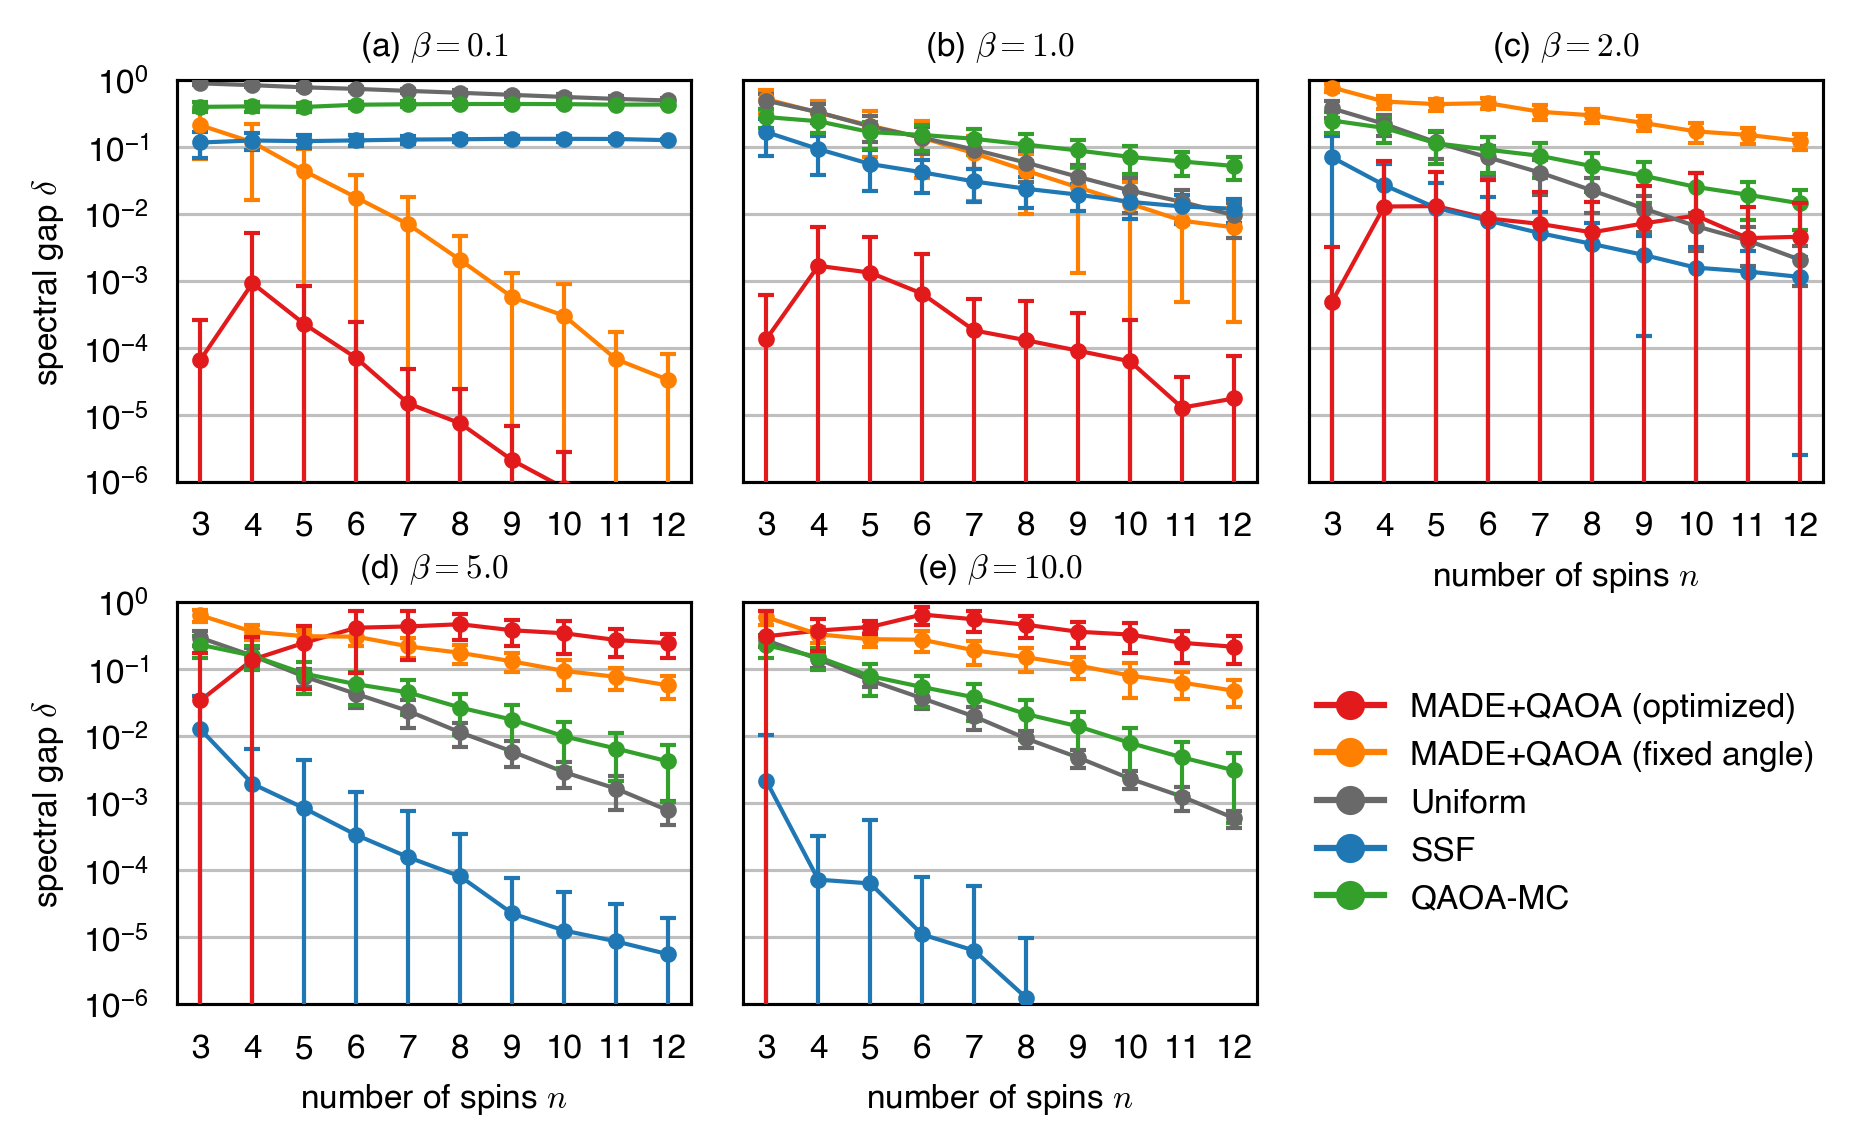

In [205]:
n_row = 2
n_col = 3

capsize = 2
markersize = 3
elinewidth = 1
capthick = 1
linewidth = 1
spines = 0.75
fontsize = 8

num_list = list(string.ascii_lowercase)[0:5]

fig1, ax1 = plt.subplots(n_row, n_col, figsize=(7.08, 4), gridspec_kw=dict(wspace=0.1, hspace=0.3), dpi=300)

for i in range(len(beta_list)):
	row = i // n_col
	col = i % n_col
	
	print(n_spin_list.shape, mean_gap_data[i,:,0].shape)
	#ax1[row,col].errorbar(n_spin_list, mean_gap_data[i,:,0], std_gap_data[i,:,0], color=red, linestyle='none', marker='o', markersize=markersize, capsize=capsize, capthick=capthick, elinewidth=elinewidth, label='MADE+QAOA (optimized)', zorder=5)
	#ax1[row,col].errorbar(n_spin_list, mean_gap_data[i,:,1], std_gap_data[i,:,1], color=orange, linestyle='none', marker='o', markersize=markersize, capsize=capsize, capthick=capthick, elinewidth=elinewidth, label='MADE+QAOA (fixed angle)', zorder=4)
	ax1[row,col].errorbar(n_spin_list, mean_gap_add_data[i,:,0], std_gap_add_data[i,:,0], color=red, linestyle='none', marker='o', markersize=markersize, capsize=capsize, capthick=capthick, elinewidth=elinewidth, label='MADE+QAOA (optimized)', zorder=5)
	ax1[row,col].errorbar(n_spin_list, mean_gap_add_data[i,:,1], std_gap_add_data[i,:,1], color=orange, linestyle='none', marker='o', markersize=markersize, capsize=capsize, capthick=capthick, elinewidth=elinewidth, label='MADE+QAOA (fixed angle)', zorder=4)
	ax1[row,col].errorbar(n_spin_list, mean_gap_data[i,:,2], std_gap_data[i,:,2], color='dimgrey', linestyle='none', marker='o', markersize=markersize, capsize=capsize, capthick=capthick, elinewidth=elinewidth, label='Uniform,', zorder=4)
	ax1[row,col].errorbar(n_spin_list, mean_gap_data[i,:,3], std_gap_data[i,:,3], color=blue, linestyle='none', marker='o', markersize=markersize, capsize=capsize, capthick=capthick, elinewidth=elinewidth, label='SSF', zorder=4)
	ax1[row,col].errorbar(n_spin_list, mean_gap_data[i,:,4], std_gap_data[i,:,4], color=green, linestyle='none', marker='o', markersize=markersize, capsize=capsize, capthick=capthick, elinewidth=elinewidth, label='QAOA-MC', zorder=4)
	ax1[row,col].set_xticks(n_spin_list)
 
	#ax1[row,col].plot(n_spin_list, mean_gap_data[i,:,0], color=red, linewidth=linewidth)
	#ax1[row,col].plot(n_spin_list, mean_gap_data[i,:,1], color=orange, linewidth=linewidth)
	ax1[row,col].plot(n_spin_list, mean_gap_add_data[i,:,0], color=red, linewidth=linewidth)
	ax1[row,col].plot(n_spin_list, mean_gap_add_data[i,:,1], color=orange, linewidth=linewidth)
	ax1[row,col].plot(n_spin_list, mean_gap_data[i,:,2], color='dimgrey', linewidth=linewidth)
	ax1[row,col].plot(n_spin_list, mean_gap_data[i,:,3], color=blue, linewidth=linewidth)
	ax1[row,col].plot(n_spin_list, mean_gap_data[i,:,4], color=green, linewidth=linewidth)
	ax1[row,col].grid(axis='y', color='#BFBFBF', linestyle='-', linewidth=spines)
 
	ax1[row,col].set_axisbelow(True) #gridを背面にする

	ax1[row,col].spines["top"].set_linewidth(spines)
	ax1[row,col].spines["left"].set_linewidth(spines)
	ax1[row,col].spines["bottom"].set_linewidth(spines)
	ax1[row,col].spines["right"].set_linewidth(spines)
	
	ax1[row,col].set_yscale("log")
	ax1[row,col].set_ylim(1e-6, 1e0)
	ax1[row,col].minorticks_off()
	ax1[row,col].set_title(r'({1}) $\beta={0}$'.format(beta_list[i],num_list[i]),{"fontsize": fontsize})
	ax1[row,col].tick_params(width=0.0, labelsize=fontsize)
	if col != 0:
		ax1[row, col].tick_params(labelleft=False)

ax1[1,0].set_xlabel(r'number of spins $n$', fontsize=fontsize)
ax1[1,1].set_xlabel(r'number of spins $n$', fontsize=fontsize)
ax1[0,2].set_xlabel(r'number of spins $n$', fontsize=fontsize)
ax1[0,0].set_ylabel(r'spectral gap $\delta$', fontsize=fontsize)
ax1[1,0].set_ylabel(r'spectral gap $\delta$', fontsize=fontsize)
  
ax1[-1,-1].plot([], [], marker='o', color=red, label='MADE+QAOA (optimized)', linestyle=None)
ax1[-1,-1].plot([], [], marker='o', color=orange, label='MADE+QAOA (fixed angle)', linestyle=None)
ax1[-1,-1].plot([], [], marker='o', color='dimgrey', label='Uniform', linestyle=None)
ax1[-1,-1].plot([], [], marker='o', color=blue, label='SSF', linestyle=None)
ax1[-1,-1].plot([], [], marker='o', color=green, label='QAOA-MC', linestyle=None)

for spine in ax1[-1,-1].spines.values():
    spine.set_visible(False)
ax1[-1,-1].axes.get_xaxis().set_visible(False)
ax1[-1,-1].axes.get_yaxis().set_visible(False)

ax1[-1,-1].legend(fontsize=fontsize, bbox_to_anchor=(0.5,0.5), loc='center', frameon=False)

fig1.savefig("figure/spectral_gap.svg", dpi=300, bbox_inches='tight')
#fig1.savefig("figure/ave_gap_vs_qubit.png", dpi=300)

### $\beta=10$について

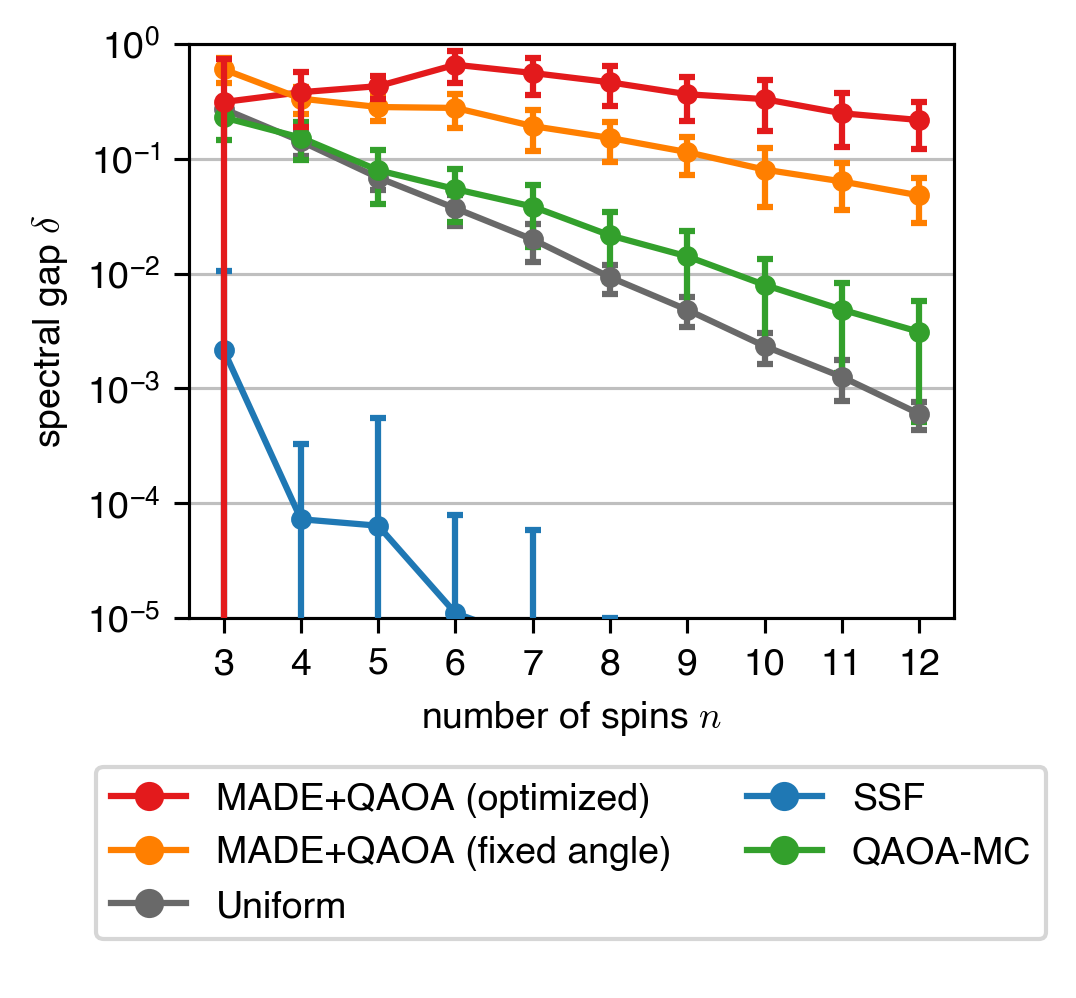

In [ ]:
capsize = 2
markersize = 4
elinewidth = 1.5
capthick = 1.5
linewidth = 1.5
spines = 0.75
fontsize = 9

fig1_1, ax1_1 = plt.subplots(2,1, figsize=(3.29,4), gridspec_kw=dict(height_ratios=[5,2], hspace=0.3), dpi=300)

ax1_1[0].errorbar(n_spin_list, mean_gap_add_data[4,:,0], std_gap_add_data[4,:,0], color=red, linestyle='none', marker='o', markersize=markersize, capsize=capsize, capthick=capthick, elinewidth=elinewidth, label='MADE+QAOA (optimized)', zorder=5)
ax1_1[0].errorbar(n_spin_list, mean_gap_add_data[4,:,1], std_gap_add_data[4,:,1], color=orange, linestyle='none', marker='o', markersize=markersize, capsize=capsize, capthick=capthick, elinewidth=elinewidth, label='MADE+QAOA (fixed angle)', zorder=4)
ax1_1[0].errorbar(n_spin_list, mean_gap_data[4,:,2], std_gap_data[4,:,2], color='dimgrey', linestyle='none', marker='o', markersize=markersize, capsize=capsize, capthick=capthick, elinewidth=elinewidth, label='Uniform', zorder=4)
ax1_1[0].errorbar(n_spin_list, mean_gap_data[4,:,3], std_gap_data[4,:,3], color=blue, linestyle='none', marker='o', markersize=markersize, capsize=capsize, capthick=capthick, elinewidth=elinewidth, label='SSF', zorder=4)
ax1_1[0].errorbar(n_spin_list, mean_gap_data[4,:,4], std_gap_data[4,:,4], color=green, linestyle='none', marker='o', markersize=markersize, capsize=capsize, capthick=capthick, elinewidth=elinewidth, label='QAOA-MC', zorder=4)
ax1_1[0].set_xticks(n_spin_list)

ax1_1[0].plot(n_spin_list, mean_gap_add_data[4,:,0], color=red, linewidth=linewidth)
ax1_1[0].plot(n_spin_list, mean_gap_add_data[4,:,1], color=orange, linewidth=linewidth)
ax1_1[0].plot(n_spin_list, mean_gap_data[4,:,2], color='dimgrey', linewidth=linewidth)
ax1_1[0].plot(n_spin_list, mean_gap_data[4,:,3], color=blue, linewidth=linewidth)
ax1_1[0].plot(n_spin_list, mean_gap_data[4,:,4], color=green, linewidth=linewidth)
ax1_1[0].grid(axis='y', color='#BFBFBF', linestyle='-', linewidth=spines)

ax1_1[0].set_axisbelow(True) #gridを背面にする
ax1_1[0].spines["top"].set_linewidth(spines)
ax1_1[0].spines["left"].set_linewidth(spines)
ax1_1[0].spines["bottom"].set_linewidth(spines)
ax1_1[0].spines["right"].set_linewidth(spines)

ax1_1[0].set_yscale("log")
ax1_1[0].set_ylim(1e-5, 1e0)
ax1_1[0].set_xlabel(r'number of spins $n$', fontsize=fontsize)
ax1_1[0].set_ylabel(r'spectral gap $\delta$', fontsize=fontsize)
ax1_1[0].tick_params(labelsize=fontsize)
ax1_1[0].tick_params(which='major', width=spines)
ax1_1[0].minorticks_off()

ax1_1[-1].plot([], [], marker='o', color=red, label='MADE+QAOA (optimized)', linestyle=None)
ax1_1[-1].plot([], [], marker='o', color=orange, label='MADE+QAOA (fixed angle)', linestyle=None)
ax1_1[-1].plot([], [], marker='o', color='dimgrey', label='Uniform', linestyle=None)
ax1_1[-1].plot([], [], marker='o', color=blue, label='SSF', linestyle=None)
ax1_1[-1].plot([], [], marker='o', color=green, label='QAOA-MC', linestyle=None)

for spine in ax1_1[-1].spines.values():
    spine.set_visible(False)
ax1_1[-1].axes.get_xaxis().set_visible(False)
ax1_1[-1].axes.get_yaxis().set_visible(False)
ax1_1[-1].legend(fontsize=fontsize, bbox_to_anchor=(0.5,0.5), loc='center', ncol=2, frameon=True)

fig1_1.savefig("figure/spectral_gap_beta_10.svg", dpi=300, bbox_inches='tight')

### スケーリング

In [81]:
qaoa_mc_coef, qaoa_mc_cov = exp_fit_2(n_spin_list, mean_gap_data[i,:,4], std_gap_data[i,:,4])[1:3]
qaoa_mc_fit = exp_func_2(n_spin_list, qaoa_mc_coef[0], qaoa_mc_coef[1])

uni_coef, uni_cov = exp_fit(n_spin_list, mean_gap_data[i,:,2], std_gap_data[i,:,2])[1:3]
uni_fit = exp_func(n_spin_list, uni_coef[0])

qaoa_mc_uc = np.diag(np.sqrt(qaoa_mc_cov))
uni_uc = np.diag(np.sqrt(uni_cov))

u_qaoa_mc_coef = ufloat(qaoa_mc_coef[0], qaoa_mc_uc[0])
u_uni_coef = ufloat(uni_coef[0], uni_uc[0])

print("QAOA-MC : y = 2 ** (- {0} * (n + {1}) )".format(qaoa_mc_coef[0], qaoa_mc_coef[1]))
print("scaling factor(uncertainty) : k = {0}".format(u_qaoa_mc_coef))

print("Uniform : y = 2 ** (- {0} * n)".format(uni_coef[0]))
print("scaling factor(uncertainty) : k = {0}".format(u_uni_coef))

QAOA-MC : y = 2 ** (- 0.6893405839560471 * (n + 0.05812795291263751) )
scaling factor(uncertainty) : k = 0.689+/-0.012
Uniform : y = 2 ** (- 0.8598612755174042 * n)
scaling factor(uncertainty) : k = 0.860+/-0.017


/var/folders/5z/hnd7blsn33vdfn4r3xgj5_sh0000gn/T/ipykernel_2840/2277429790.py:7: RuntimeWarning: invalid value encountered in sqrt
  qaoa_mc_uc = np.diag(np.sqrt(qaoa_mc_cov))


## MCMCシミュレーション実験

### 定数

In [82]:
n_spin = 25
beta = 5.0

### データのロード

In [83]:
data_folder_name = 'result/mcmc_simulation/{0}_sites_result_01/'.format(n_spin)

# データ取得
opt_qaoa_made_result = np.load(data_folder_name+"opt_qaoa_made_result.npy")
fix_qaoa_made_result = np.load(data_folder_name+"fix_qaoa_made_result.npy")
uniform_result = np.load(data_folder_name+"uniform_result.npy")
ssf_result = np.load(data_folder_name+"ssf_result.npy")

# インスタンス取得
source_dir_name = 'data'
fname_in = pathlib.Path(source_dir_name).joinpath('{0}_sites_instance_01.pickle'.format(n_spin))
with open(str(fname_in), 'rb') as f:
	instance = pickle.load(f)
 
# 形状確認
print(opt_qaoa_made_result.shape)
print(opt_qaoa_made_result.dtype)
# axis0: chain, axis1: step, axis2: x

(10, 100001, 25)
int8


### 磁化推定

In [84]:
n_chain = opt_qaoa_made_result.shape[0]
n_step = 100000

temp = np.arange(1, opt_qaoa_made_result.shape[1]+1)
normalize = np.tile(temp, (n_chain, 1))

# 平均磁化 (理論値)
#boltzmann_dist = ising.spin_boltzmann_distribution(instance, beta)
#true_val = ising.boltzmann_average_magnetization(n_spin, boltzmann_dist)
#print(true_val)
true_val = 0.0

# 平均磁化
opt_qaoa_made_mag = np.average(opt_qaoa_made_result, axis=2)
opt_qaoa_made_mag_hist = np.cumsum(opt_qaoa_made_mag, axis=1) / normalize
opt_qaoa_made_mag_sqrt_mean = np.average(opt_qaoa_made_mag_hist**2, axis=0)[0:n_step+1]
opt_qaoa_made_mag_sqrt_std = np.std(opt_qaoa_made_mag_hist**2, axis=0, ddof=1)[0:n_step+1]
opt_qaoa_made_mag_mean = np.average(opt_qaoa_made_mag_hist, axis=0)[0:n_step+1]
opt_qaoa_made_mag_std = np.std(opt_qaoa_made_mag_hist, axis=0, ddof=1)[0:n_step+1]

fix_qaoa_made_mag = np.average(fix_qaoa_made_result, axis=2)
fix_qaoa_made_mag_hist = np.cumsum(fix_qaoa_made_mag, axis=1) / normalize
fix_qaoa_made_mag_sqrt_mean = np.average(fix_qaoa_made_mag_hist**2, axis=0)[0:n_step+1]
fix_qaoa_made_mag_sqrt_std = np.std(fix_qaoa_made_mag_hist**2, axis=0, ddof=1)[0:n_step+1]
fix_qaoa_made_mag_mean = np.average(fix_qaoa_made_mag_hist, axis=0)[0:n_step+1]
fix_qaoa_made_mag_std = np.std(fix_qaoa_made_mag_hist, axis=0, ddof=1)[0:n_step+1]

uniform_mag = np.average(uniform_result, axis=2)
uniform_mag_hist = np.cumsum(uniform_mag, axis=1) / normalize
uniform_mag_sqrt_mean = np.average(uniform_mag_hist**2, axis=0)[0:n_step+1]
uniform_mag_sqrt_std = np.std(uniform_mag_hist**2, axis=0, ddof=1)[0:n_step+1]
uniform_mag_mean = np.average(uniform_mag_hist, axis=0)[0:n_step+1]
uniform_mag_std = np.std(uniform_mag_hist, axis=0, ddof=1)[0:n_step+1]

ssf_mag = np.average(ssf_result, axis=2)
ssf_mag_hist = np.cumsum(ssf_mag, axis=1) / normalize
ssf_mag_sqrt_mean = np.average(ssf_mag_hist**2, axis=0)[0:n_step+1]
ssf_mag_sqrt_std = np.std(ssf_mag_hist**2, axis=0, ddof=1)[0:n_step+1]
ssf_mag_mean = np.average(ssf_mag_hist, axis=0)[0:n_step+1]
ssf_mag_std = np.std(ssf_mag_hist, axis=0, ddof=1)[0:n_step+1]

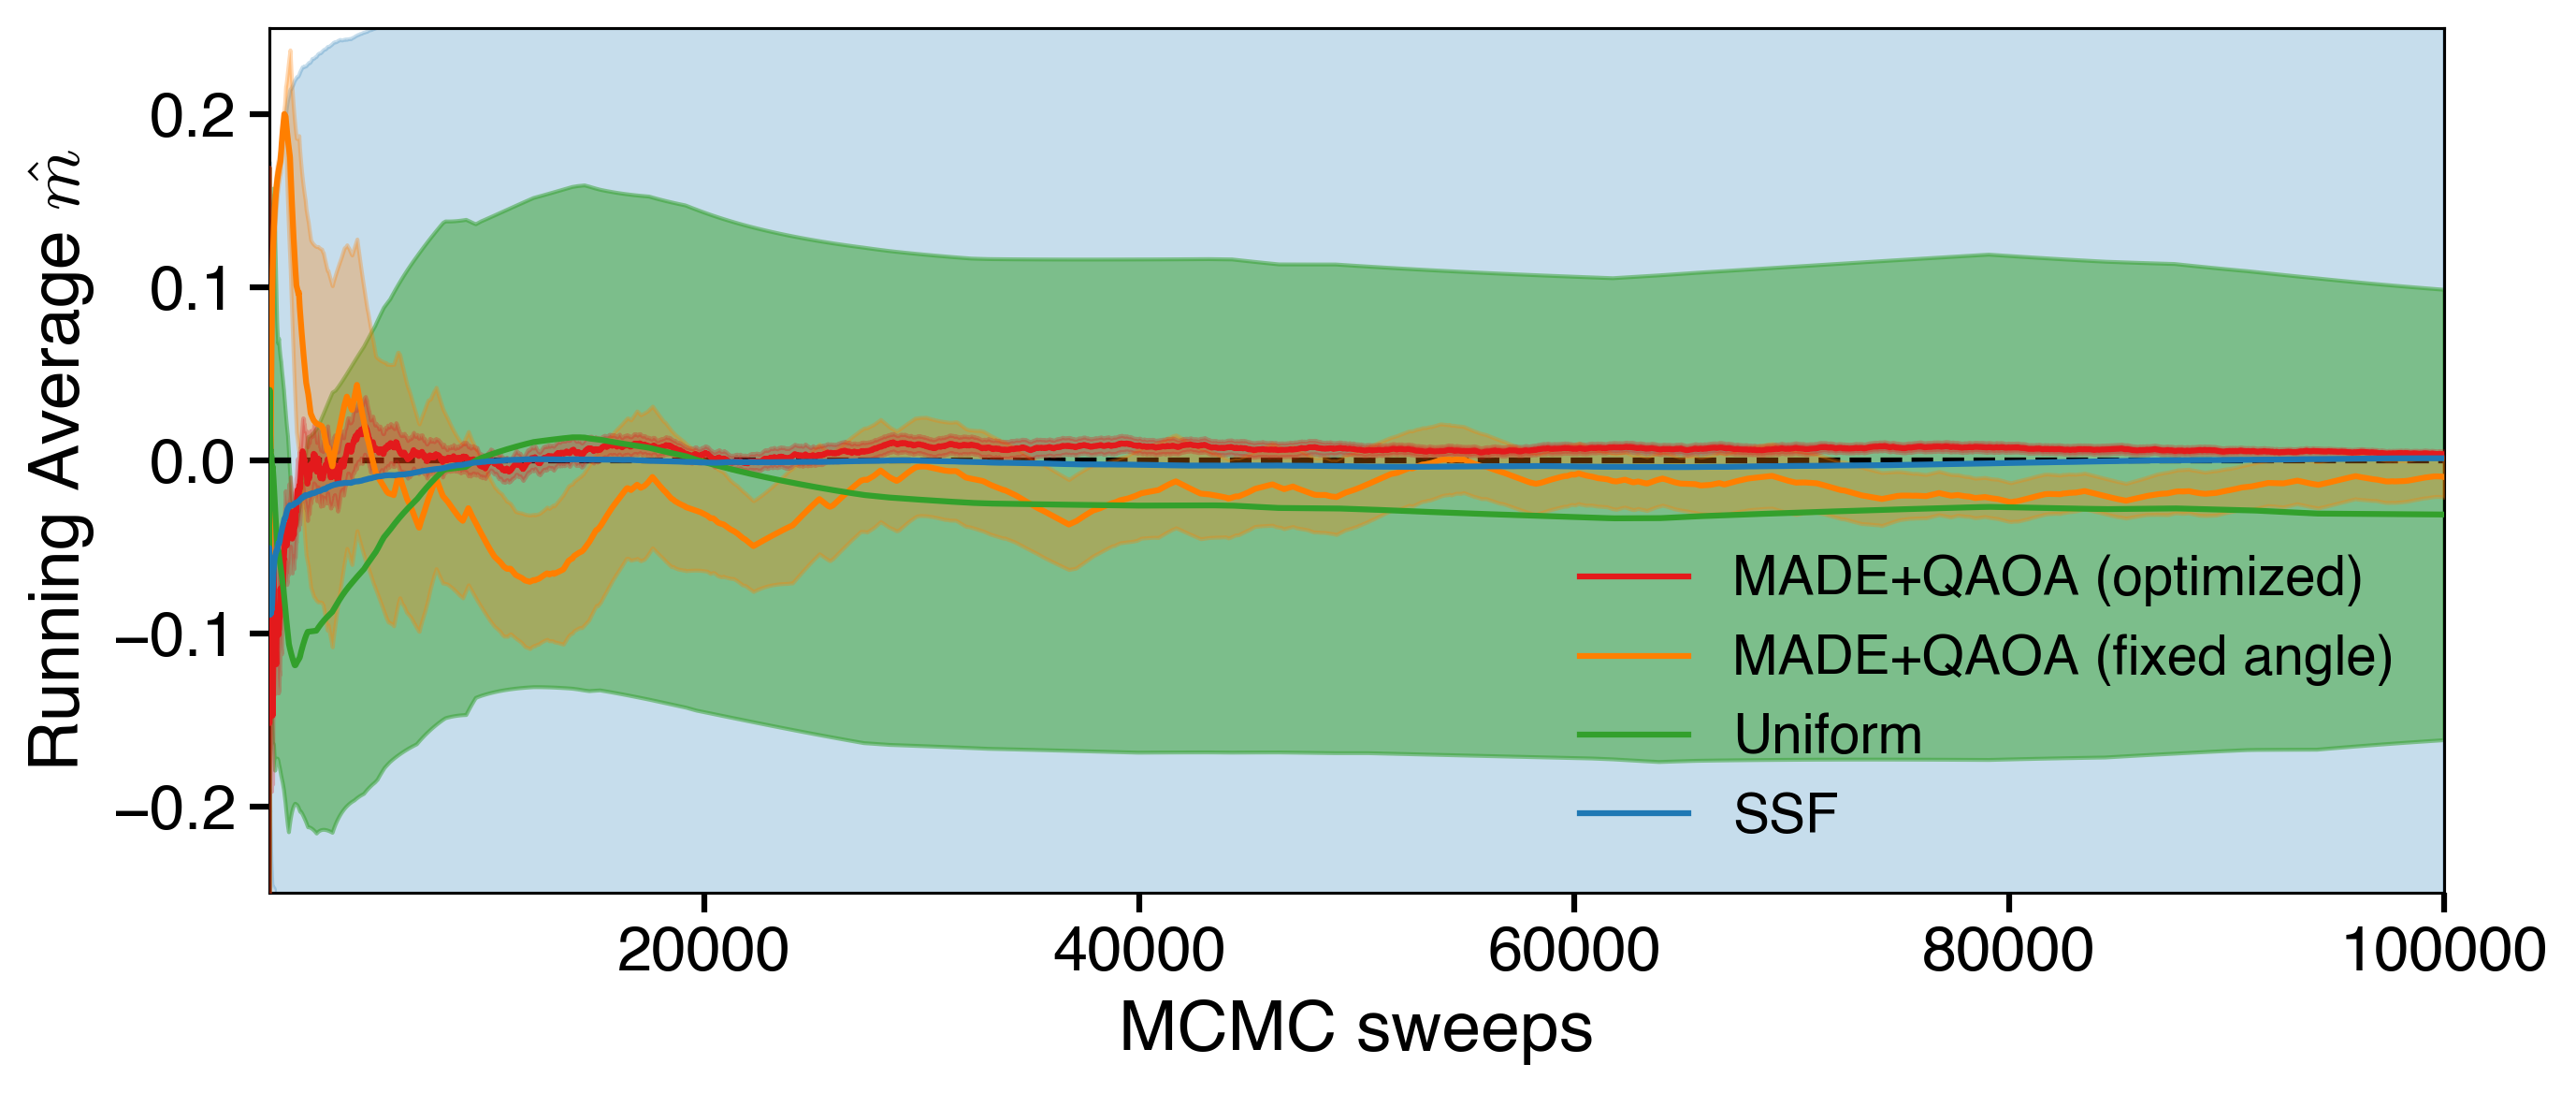

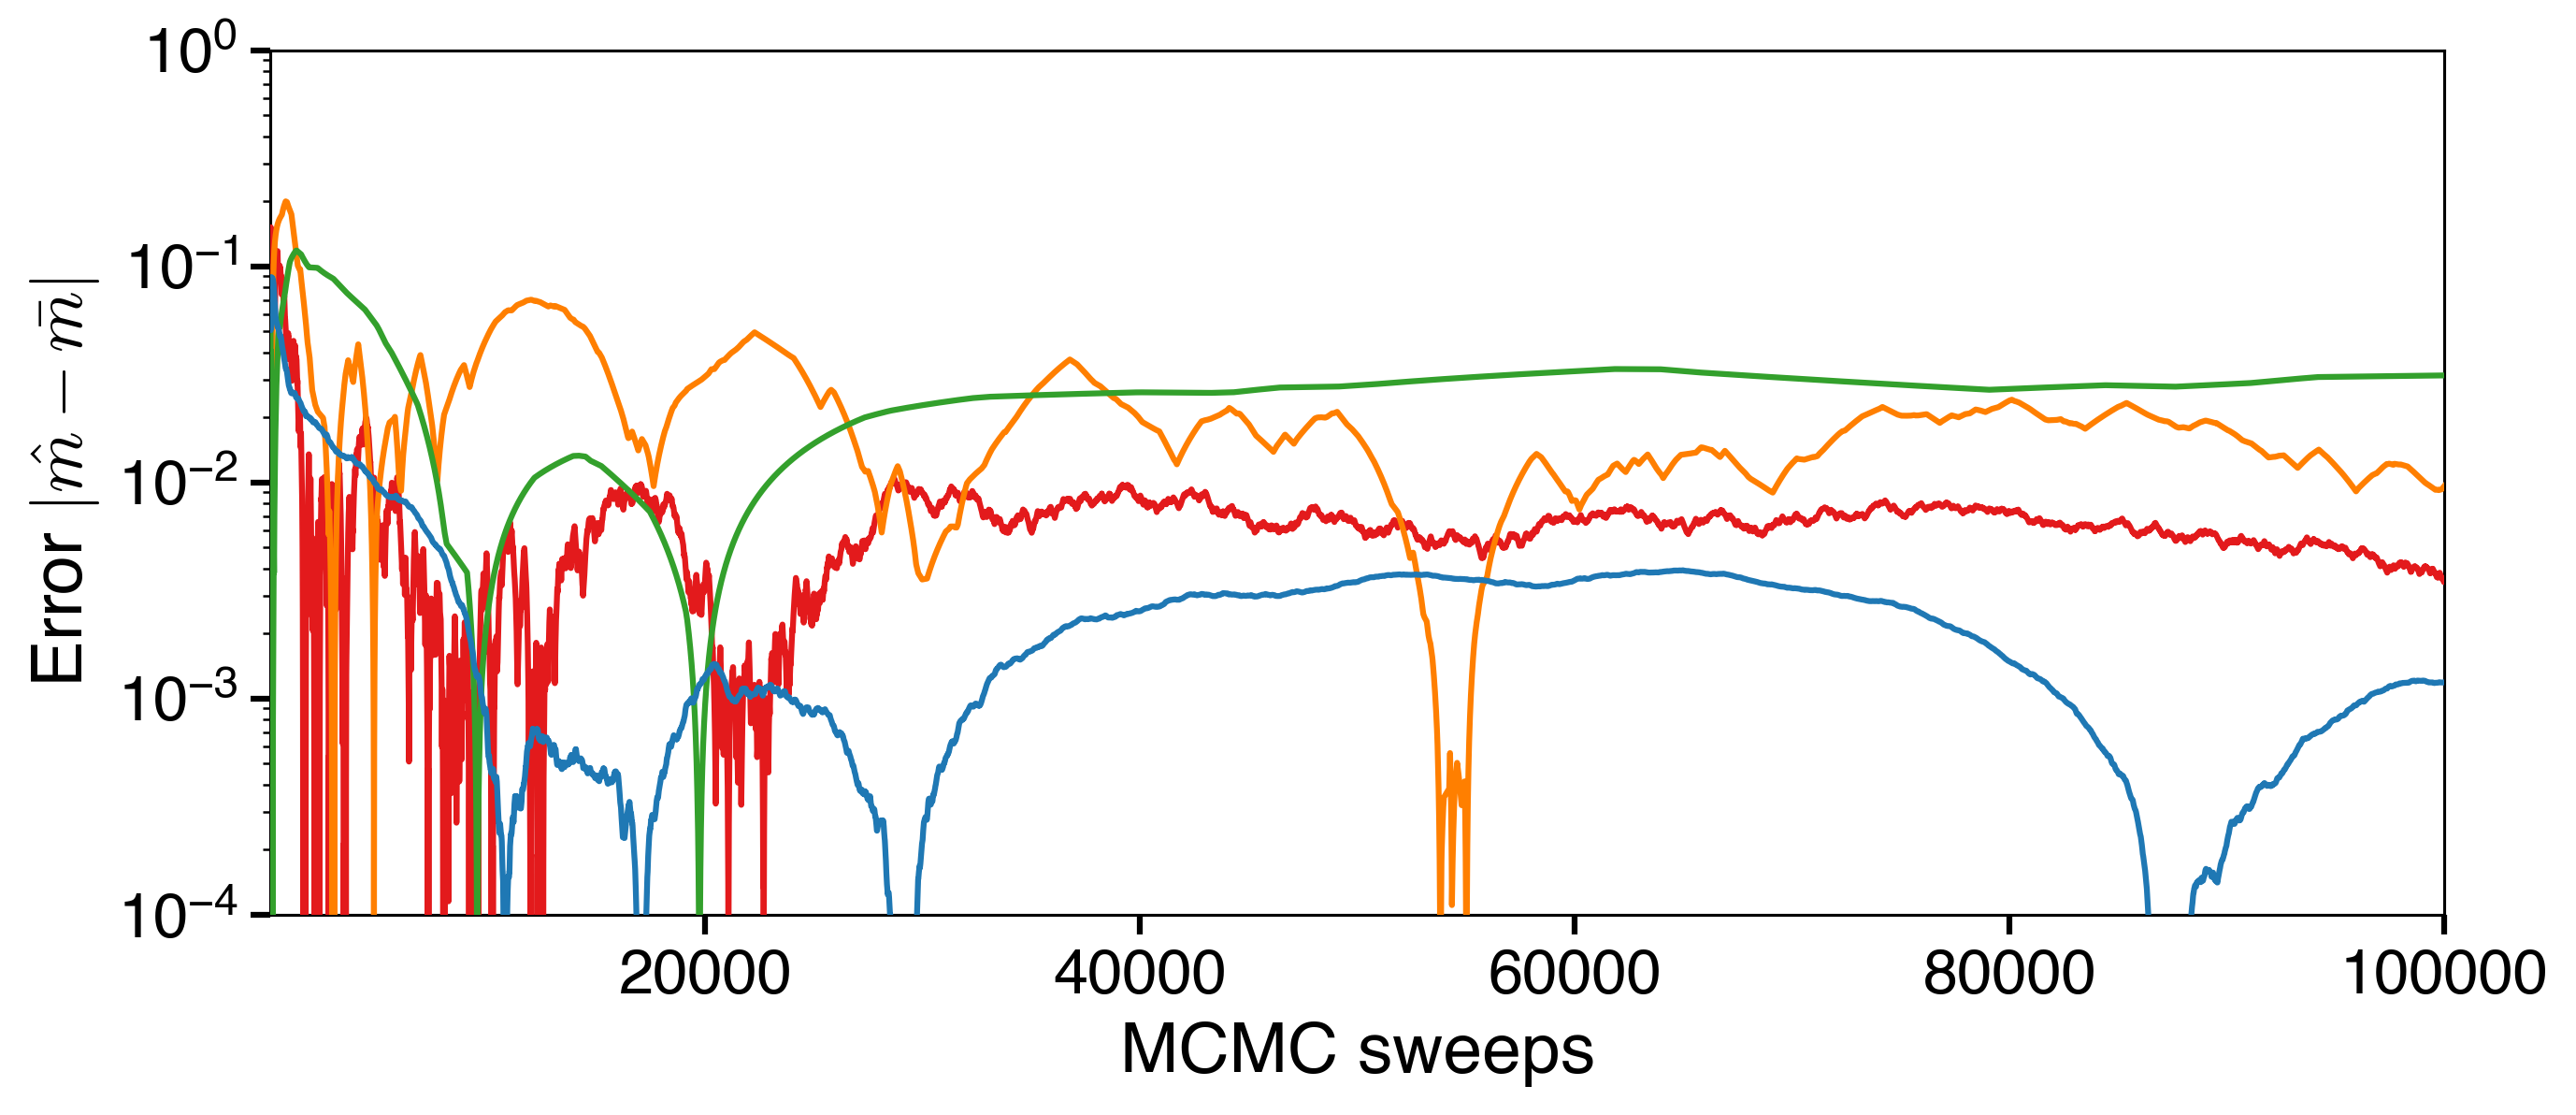

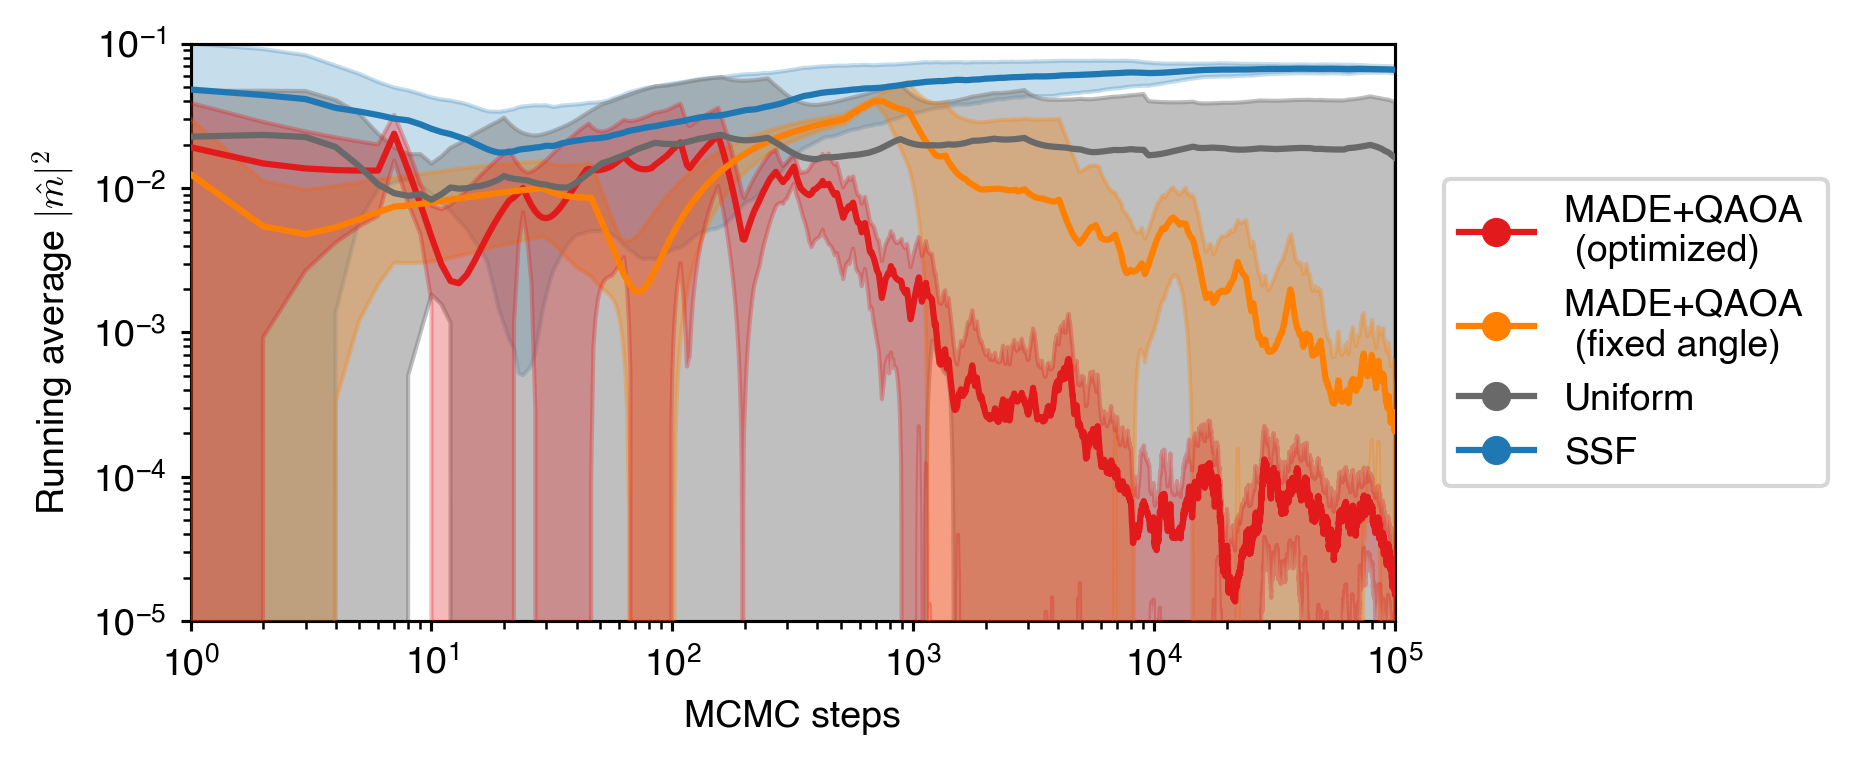

In [183]:
capsize = 2
markersize = 4
elinewidth = 1.5
capthick = 1.5
linewidth = 1.5
spines = 0.75
fontsize = 9

fig2, ax2 = plt.subplots(figsize=(10,4), dpi=300)

ax2.spines["top"].set_linewidth(spines)
ax2.spines["left"].set_linewidth(spines)
ax2.spines["bottom"].set_linewidth(spines)
ax2.spines["right"].set_linewidth(spines)

ax2.plot(np.arange(n_step+1), opt_qaoa_made_mag_mean, color=red, linewidth=linewidth, label='MADE+QAOA (optimized)', zorder=5)
ax2.fill_between(np.arange(n_step+1), opt_qaoa_made_mag_mean+opt_qaoa_made_mag_std, opt_qaoa_made_mag_mean-opt_qaoa_made_mag_std, color=red, alpha=0.3, zorder=4)

ax2.plot(np.arange(n_step+1), fix_qaoa_made_mag_mean, color=orange, linewidth=linewidth, label='MADE+QAOA (fixed angle)', zorder=5)
ax2.fill_between(np.arange(n_step+1), fix_qaoa_made_mag_mean+fix_qaoa_made_mag_std, fix_qaoa_made_mag_mean-fix_qaoa_made_mag_std, color=orange, alpha=0.3, zorder=3)

ax2.plot(np.arange(n_step+1), uniform_mag_mean, color=green, linewidth=linewidth, label='Uniform', zorder=5)
ax2.fill_between(np.arange(n_step+1), uniform_mag_mean+uniform_mag_std, uniform_mag_mean-uniform_mag_std, color=green, alpha=0.5, zorder=2)

ax2.plot(np.arange(n_step+1), ssf_mag_mean, color=blue, linewidth=linewidth, label='SSF', zorder=5)
ax2.fill_between(np.arange(n_step+1), ssf_mag_mean+ssf_mag_std, ssf_mag_mean-ssf_mag_std, color=blue, alpha=0.25, zorder=1)

ax2.axhline(true_val, color='black', linestyle='--', linewidth=linewidth)

ax2.set_xlim(1, n_step)
#ax2.set_xscale('log')
ax2.set_ylim(-0.25,0.25)
ax2.set_xlabel('MCMC sweeps', fontsize=18)
ax2.set_ylabel(r'Running Average $\hat{m}$', fontsize=18)
ax2.tick_params(width=1.5, labelsize=16, length=5, labelbottom=True)
ax2.tick_params(axis="x", which='major', width=1.5)
ax2.legend(fontsize=14, loc='lower right', frameon=False)

fig2_2, ax2_2 = plt.subplots(figsize=(10,4), dpi=300)

ax2_2.spines["top"].set_linewidth(spines)
ax2_2.spines["left"].set_linewidth(spines)
ax2_2.spines["bottom"].set_linewidth(spines)
ax2_2.spines["right"].set_linewidth(spines)

ax2_2.plot(np.arange(n_step+1), np.abs(opt_qaoa_made_mag_mean-true_val), color=red, linewidth=linewidth, label='MADE+QAOA (optimized)', zorder=5)
ax2_2.plot(np.arange(n_step+1), np.abs(fix_qaoa_made_mag_mean-true_val), color=orange, linewidth=linewidth, label='MADE+QAOA (fixed angle)', zorder=5)
ax2_2.plot(np.arange(n_step+1), np.abs(uniform_mag_mean-true_val), color=green, linewidth=linewidth, label='Uniform', zorder=5)
ax2_2.plot(np.arange(n_step+1), np.abs(ssf_mag_mean-true_val), color=blue, linewidth=linewidth, label='SSF', zorder=5)

ax2_2.set_yscale('log')
ax2_2.set_xlim(1, n_step)
#ax2_2.set_xscale('log')
ax2_2.set_ylim(1e-4, 1e0)
ax2_2.set_xlabel('MCMC sweeps', fontsize=18)
ax2_2.set_ylabel(r'Error $|\hat{m} - \bar{m}|$', fontsize=18)
ax2_2.tick_params(width=1.5, labelsize=16, length=5, labelbottom=True)
ax2_2.tick_params(axis="x", which='major', width=1.5)
#ax2_2.legend(fontsize=14, loc='lower right', frameon=False)

#fig2.savefig("figure/mag_est_ave_result.svg", dpi=300, bbox_inches='tight')
#fig2.savefig("figure/mag_est_ave_result.png", dpi=300, bbox_inches='tight')

#fig2_2.savefig("figure/mag_est_error_result.svg", dpi=300, bbox_inches='tight')
#fig2_2.savefig("figure/mag_est_error_result.png", dpi=300, bbox_inches='tight')

fig2_3, ax2_3 = plt.subplots(1,2, figsize=(7.08,2.5), gridspec_kw=dict(width_ratios=[3,1], wspace=0.05), dpi=300)

ax2_3[0].spines["top"].set_linewidth(spines)
ax2_3[0].spines["left"].set_linewidth(spines)
ax2_3[0].spines["bottom"].set_linewidth(spines)
ax2_3[0].spines["right"].set_linewidth(spines)

ax2_3[0].plot(np.arange(n_step+1), opt_qaoa_made_mag_sqrt_mean, color=red, linewidth=linewidth, label='MADE+QAOA (optimized)', zorder=5)
ax2_3[0].fill_between(np.arange(n_step+1), opt_qaoa_made_mag_sqrt_mean+opt_qaoa_made_mag_sqrt_std, opt_qaoa_made_mag_sqrt_mean-opt_qaoa_made_mag_sqrt_std, color=red, alpha=0.3, zorder=4)

ax2_3[0].plot(np.arange(n_step+1), fix_qaoa_made_mag_sqrt_mean, color=orange, linewidth=linewidth, label='MADE+QAOA (fixed angle)', zorder=5)
ax2_3[0].fill_between(np.arange(n_step+1), fix_qaoa_made_mag_sqrt_mean+fix_qaoa_made_mag_sqrt_std, fix_qaoa_made_mag_sqrt_mean-fix_qaoa_made_mag_sqrt_std, color=orange, alpha=0.3, zorder=3)

ax2_3[0].plot(np.arange(n_step+1), uniform_mag_sqrt_mean, color='dimgrey', linewidth=linewidth, label='Uniform', zorder=5)
ax2_3[0].fill_between(np.arange(n_step+1), uniform_mag_sqrt_mean+uniform_mag_sqrt_std, uniform_mag_sqrt_mean-uniform_mag_sqrt_std, color='grey', alpha=0.5, zorder=2)

ax2_3[0].plot(np.arange(n_step+1), ssf_mag_sqrt_mean, color=blue, linewidth=linewidth, label='SSF', zorder=5)
ax2_3[0].fill_between(np.arange(n_step+1), ssf_mag_sqrt_mean+ssf_mag_sqrt_std, ssf_mag_sqrt_mean-ssf_mag_sqrt_std, color=blue, alpha=0.25, zorder=1)

ax2_3[0].axhline(true_val, color='black', linestyle='--', linewidth=linewidth)

ax2_3[0].set_xlim(1, n_step)
ax2_3[0].set_yscale('log')
ax2_3[0].set_xscale('log')
ax2_3[0].set_ylim(1e-5,1e-1)
ax2_3[0].set_xlabel('MCMC steps', fontsize=fontsize)
ax2_3[0].set_ylabel(r'Running average ${|\hat{m}|}^2$', fontsize=fontsize)
ax2_3[0].tick_params(width=spines, labelsize=fontsize, length=2.5, labelbottom=True)
ax2_3[0].tick_params(axis="x", which='major', width=spines)

ax2_3[-1].plot([], [], marker='o', color=red, label='MADE+QAOA \n (optimized)', linestyle=None)
ax2_3[-1].plot([], [], marker='o', color=orange, label='MADE+QAOA \n (fixed angle)', linestyle=None)
ax2_3[-1].plot([], [], marker='o', color='dimgrey', label='Uniform', linestyle=None)
ax2_3[-1].plot([], [], marker='o', color=blue, label='SSF', linestyle=None)

for spine in ax2_3[-1].spines.values():
    spine.set_visible(False)
ax2_3[-1].axes.get_xaxis().set_visible(False)
ax2_3[-1].axes.get_yaxis().set_visible(False)
ax2_3[-1].legend(fontsize=fontsize, bbox_to_anchor=(0.5,0.5), loc='center', frameon=True)

fig2_3.savefig("figure/sqrt_average_magnetization.png", dpi=300, bbox_inches='tight')

### エネルギー遷移

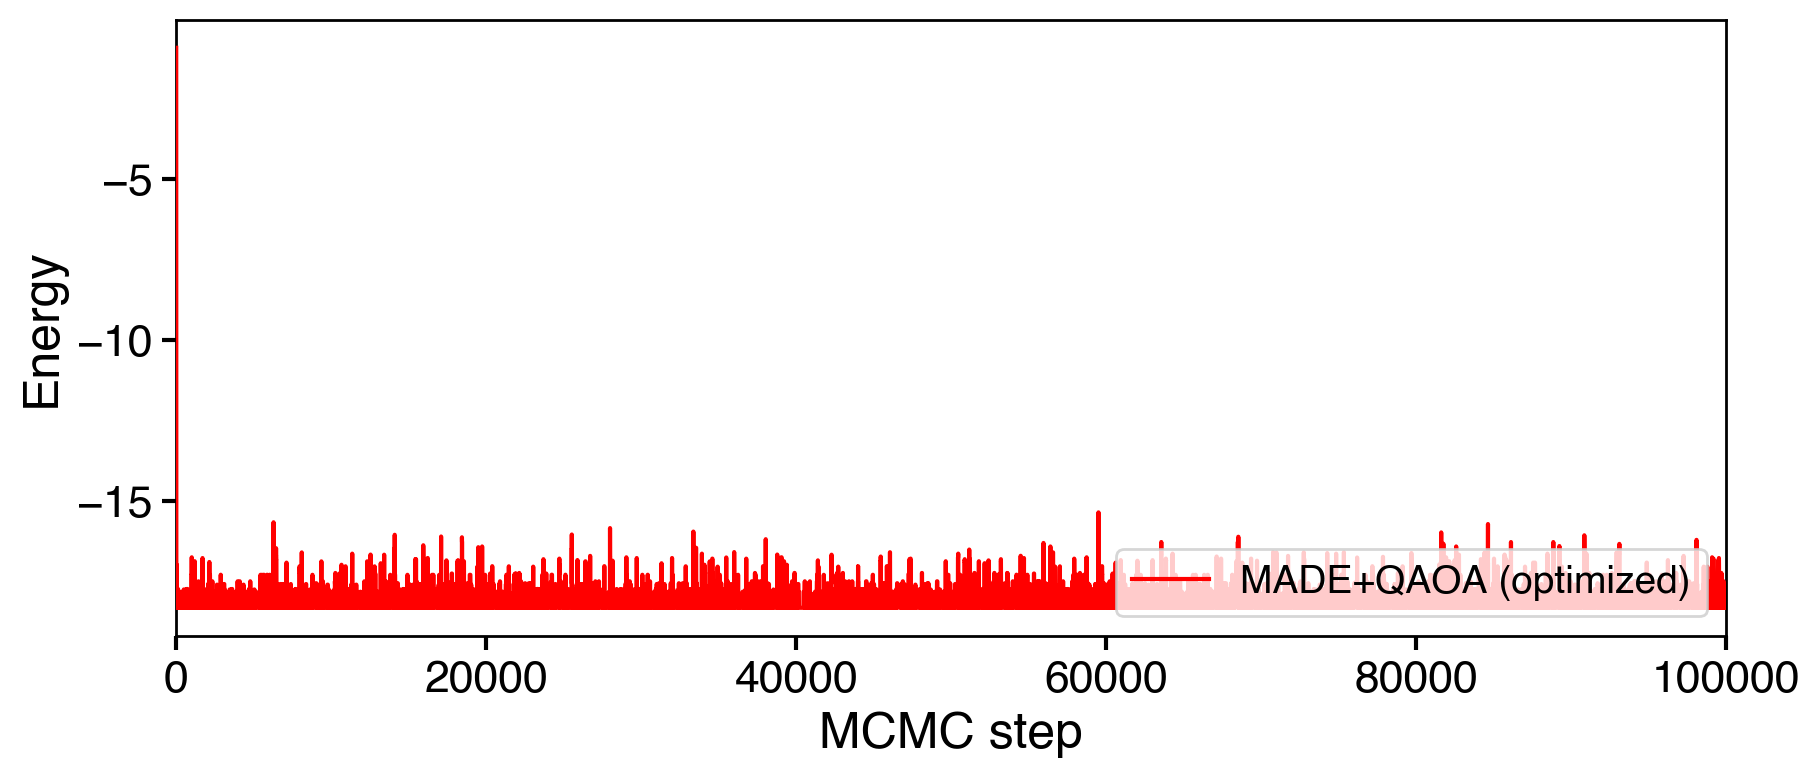

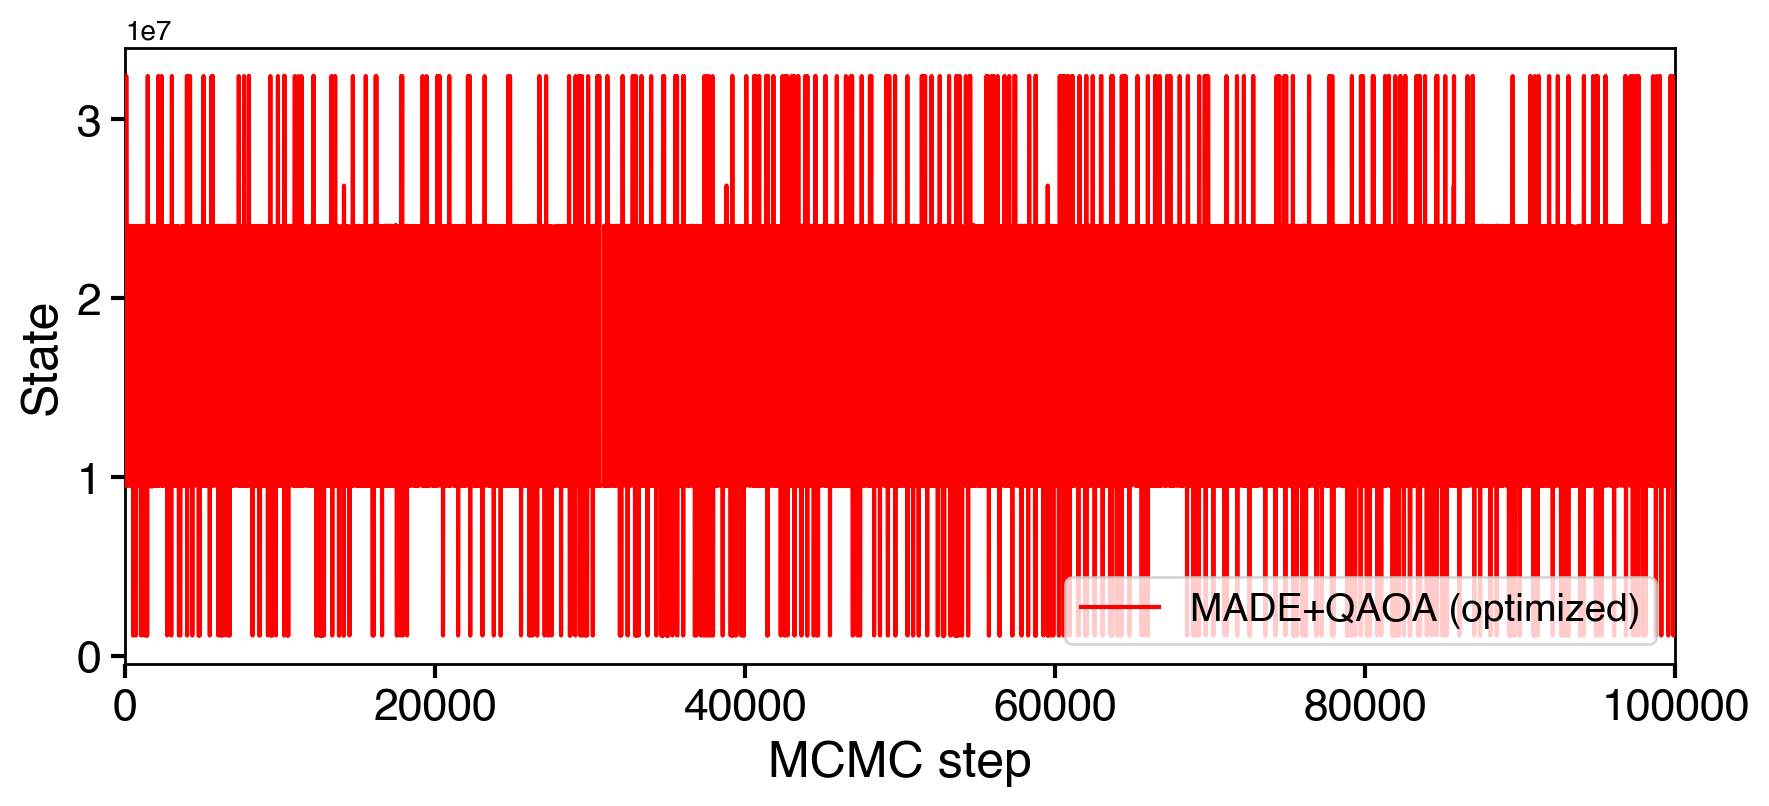

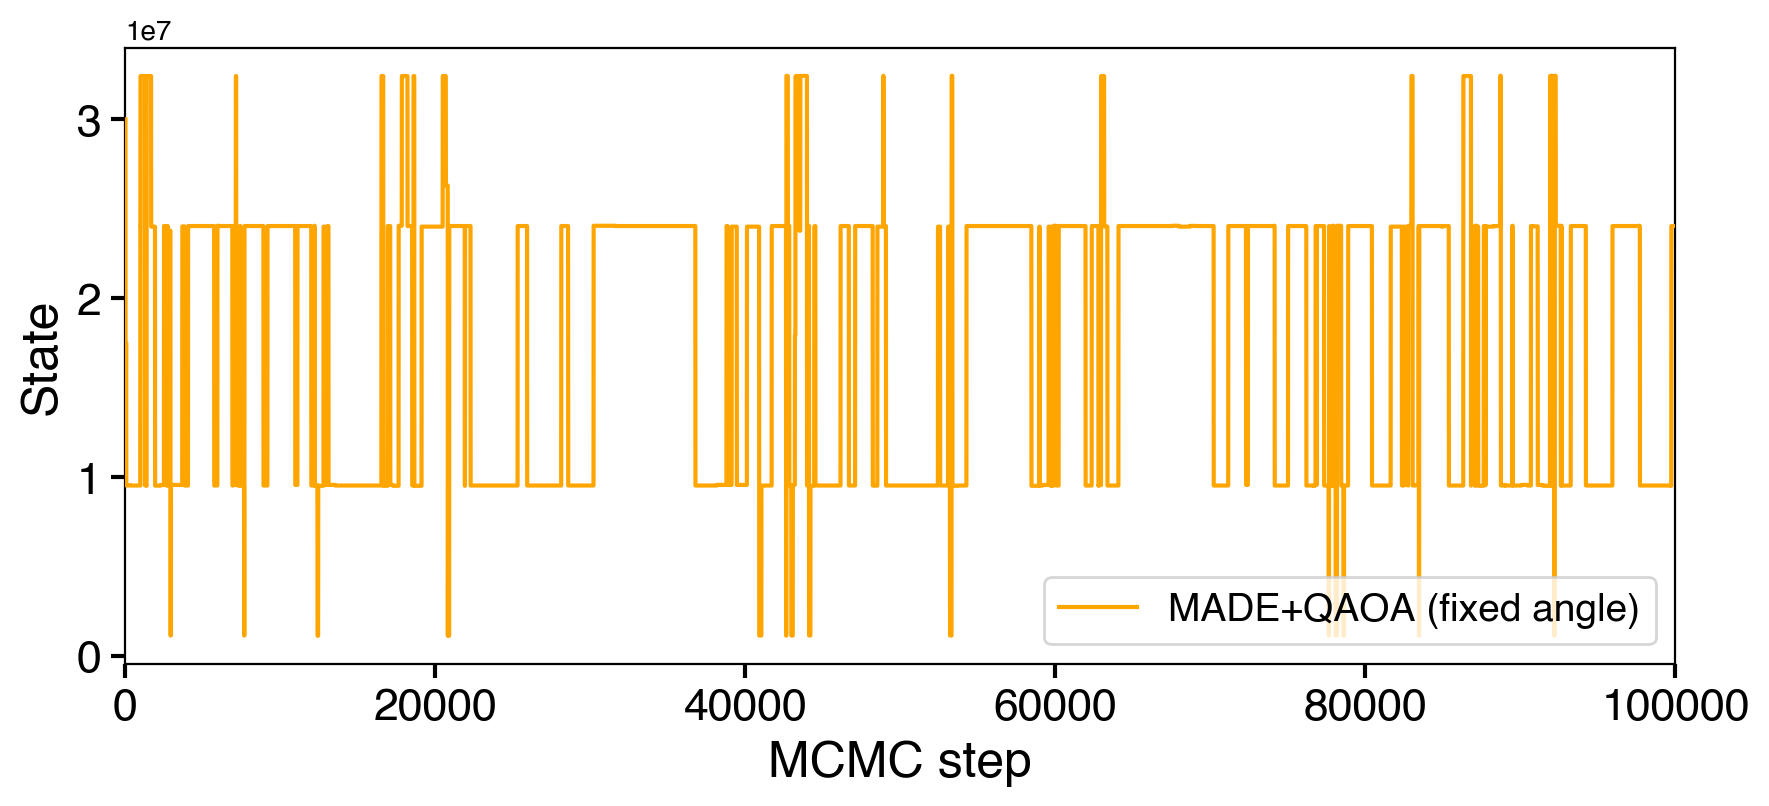

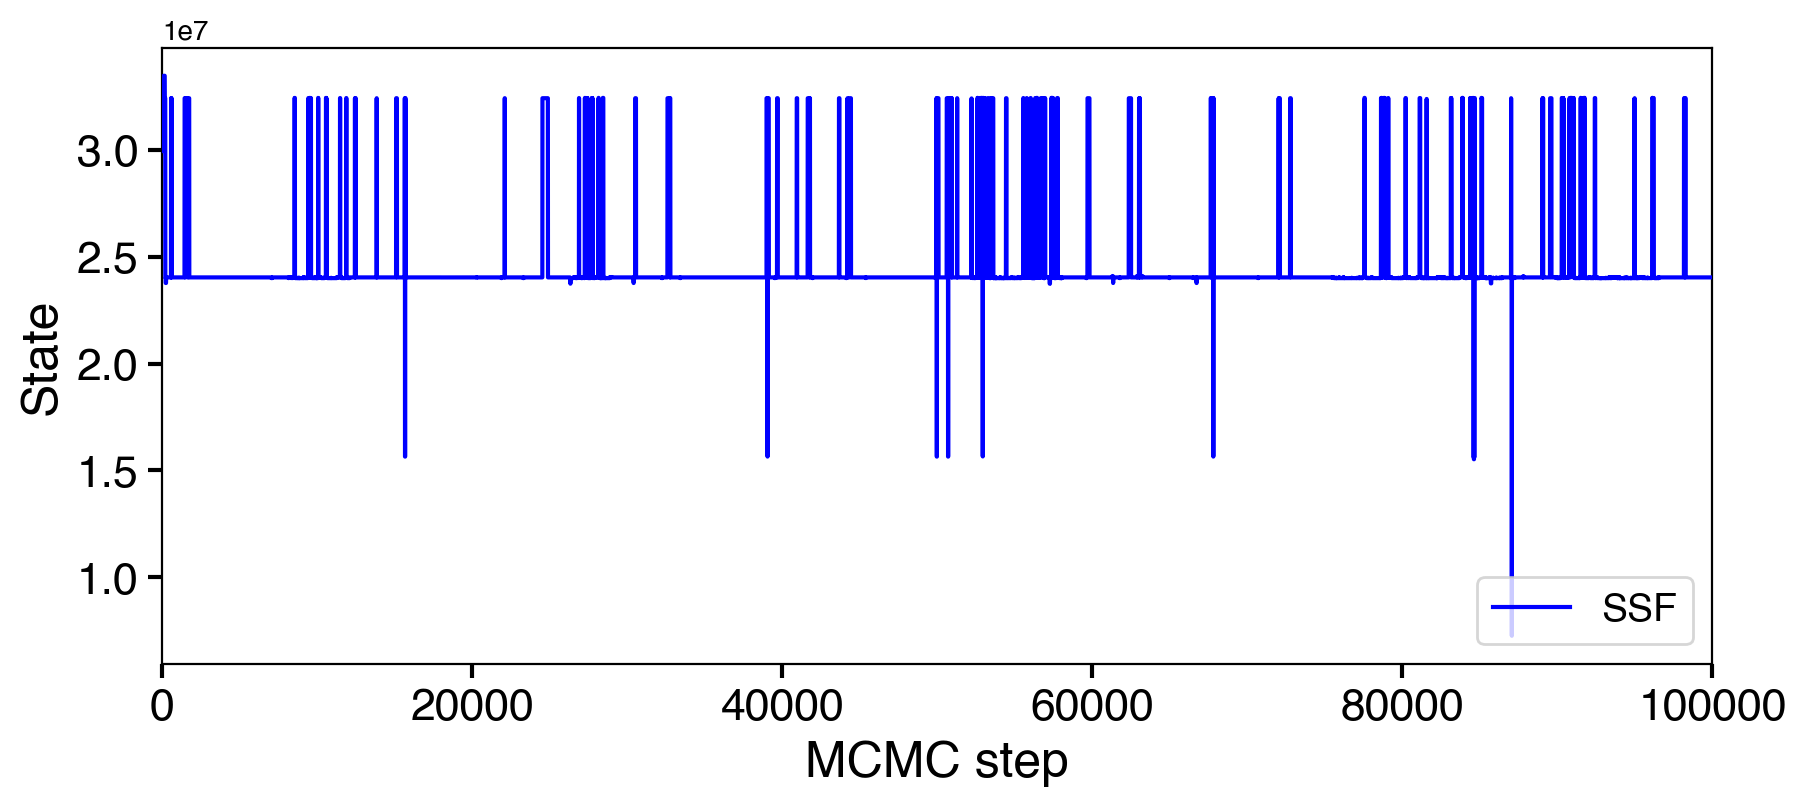

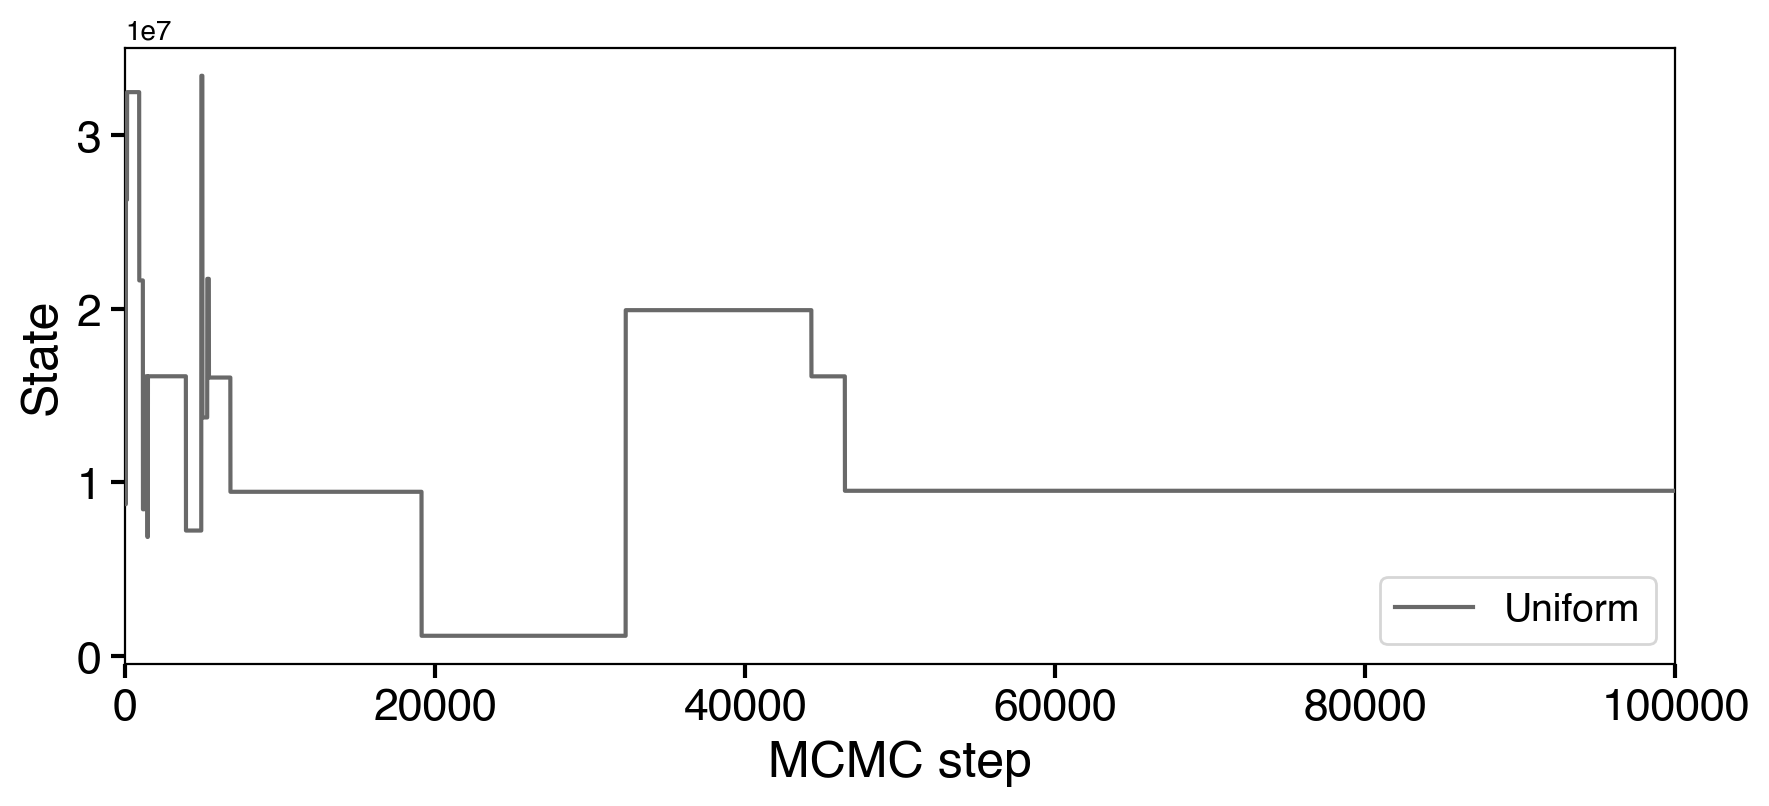

In [86]:
idx=8

opt_energy_hist = np.array([ising.spin_energy(opt_qaoa_made_result[idx,i], instance) for i in range(n_step+1)])
opt_state_hist = np.array([ising.spin_to_number(opt_qaoa_made_result[idx,i]) for i in range(n_step+1)])
fix_state_hist = np.array([ising.spin_to_number(fix_qaoa_made_result[idx,i]) for i in range(n_step+1)])
ssf_state_hist = np.array([ising.spin_to_number(ssf_result[idx,i]) for i in range(n_step+1)])
uni_state_hist = np.array([ising.spin_to_number(uniform_result[idx,i]) for i in range(n_step+1)])

fig3_1, ax3_1 = plt.subplots(figsize=(10,4), dpi=200)

ax3_1.spines["top"].set_linewidth(spines)
ax3_1.spines["left"].set_linewidth(spines)
ax3_1.spines["bottom"].set_linewidth(spines)
ax3_1.spines["right"].set_linewidth(spines)

ax3_1.plot(np.arange(n_step+1), opt_energy_hist, color='red', linewidth=linewidth, label='MADE+QAOA (optimized)', zorder=5)

ax3_1.set_xlim(0, n_step)
ax3_1.set_xlabel('MCMC step', fontsize=18)
ax3_1.set_ylabel('Energy', fontsize=18)
ax3_1.tick_params(width=1.5, labelsize=16, length=5, labelbottom=True)
ax3_1.tick_params(axis="x", which='major', width=1.5)
ax3_1.legend(fontsize=14, loc='lower right', frameon=True)

fig3_2, ax3_2 = plt.subplots(figsize=(10,4), dpi=200)

ax3_2.spines["top"].set_linewidth(spines)
ax3_2.spines["left"].set_linewidth(spines)
ax3_2.spines["bottom"].set_linewidth(spines)
ax3_2.spines["right"].set_linewidth(spines)

ax3_2.plot(np.arange(n_step+1), opt_state_hist, color='red', linewidth=linewidth, label='MADE+QAOA (optimized)', zorder=5)

ax3_2.set_xlim(0, n_step)
ax3_2.set_xlabel('MCMC step', fontsize=18)
ax3_2.set_ylabel('State', fontsize=18)
ax3_2.tick_params(width=1.5, labelsize=16, length=5, labelbottom=True)
ax3_2.tick_params(axis="x", which='major', width=1.5)
ax3_2.legend(fontsize=14, loc='lower right', frameon=True)

fig3_3, ax3_3 = plt.subplots(figsize=(10,4), dpi=200)

ax3_3.plot(np.arange(n_step+1), fix_state_hist, color='orange', linewidth=linewidth, label='MADE+QAOA (fixed angle)', zorder=5)

ax3_3.set_xlim(0, n_step)
ax3_3.set_xlabel('MCMC step', fontsize=18)
ax3_3.set_ylabel('State', fontsize=18)
ax3_3.tick_params(width=1.5, labelsize=16, length=5, labelbottom=True)
ax3_3.tick_params(axis="x", which='major', width=1.5)
ax3_3.legend(fontsize=14, loc='lower right', frameon=True)

fig3_4, ax3_4 = plt.subplots(figsize=(10,4), dpi=200)

ax3_4.plot(np.arange(n_step+1), ssf_state_hist, color='blue', linewidth=linewidth, label='SSF', zorder=5)

ax3_4.set_xlim(0, n_step)
ax3_4.set_xlabel('MCMC step', fontsize=18)
ax3_4.set_ylabel('State', fontsize=18)
ax3_4.tick_params(width=1.5, labelsize=16, length=5, labelbottom=True)
ax3_4.tick_params(axis="x", which='major', width=1.5)
ax3_4.legend(fontsize=14, loc='lower right', frameon=True)

fig3_5, ax3_5 = plt.subplots(figsize=(10,4), dpi=200)

ax3_5.plot(np.arange(n_step+1), uni_state_hist, color='dimgrey', linewidth=linewidth, label='Uniform', zorder=5)

ax3_5.set_xlim(0, n_step)
ax3_5.set_xlabel('MCMC step', fontsize=18)
ax3_5.set_ylabel('State', fontsize=18)
ax3_5.tick_params(width=1.5, labelsize=16, length=5, labelbottom=True)
ax3_5.tick_params(axis="x", which='major', width=1.5)
ax3_5.legend(fontsize=14, loc='lower right', frameon=True)

### エネルギー自己相関関数 (除外)

In [87]:
"""
def mcmc_energy_autocorrelation(spin_history, instance, lag):
	energy_history = np.array([[ising.spin_energy(spin_history[i,j], instance) for j in range(spin_history.shape[1])] for i in range(spin_history.shape[0])])
	energy_mean = np.tile(np.average(energy_history, axis=1).reshape((energy_history.shape[0],1)), (1,spin_history.shape[1]))
	energy_acf = np.zeros((spin_history.shape[0], lag))
    
	for j in range(lag):
		if j == 0:
			energy_acf[:,j] = 1.0
		else:
			n = spin_history.shape[1] - j
			energy_acf[:,j] = np.average((energy_history[:,:n] - energy_mean[:,:n]) * (energy_history[:,-n:] - energy_mean[:,:n]), axis=1)
			energy_acf[:,j] /= np.sqrt(np.average((energy_history[:,:n] - energy_mean[:,:n])**2, axis=1) * np.average((energy_history[:,-n:] - energy_mean[:,:n])**2, axis=1))
	
	return energy_acf
"""

'\ndef mcmc_energy_autocorrelation(spin_history, instance, lag):\n\tenergy_history = np.array([[ising.spin_energy(spin_history[i,j], instance) for j in range(spin_history.shape[1])] for i in range(spin_history.shape[0])])\n\tenergy_mean = np.tile(np.average(energy_history, axis=1).reshape((energy_history.shape[0],1)), (1,spin_history.shape[1]))\n\tenergy_acf = np.zeros((spin_history.shape[0], lag))\n    \n\tfor j in range(lag):\n\t\tif j == 0:\n\t\t\tenergy_acf[:,j] = 1.0\n\t\telse:\n\t\t\tn = spin_history.shape[1] - j\n\t\t\tenergy_acf[:,j] = np.average((energy_history[:,:n] - energy_mean[:,:n]) * (energy_history[:,-n:] - energy_mean[:,:n]), axis=1)\n\t\t\tenergy_acf[:,j] /= np.sqrt(np.average((energy_history[:,:n] - energy_mean[:,:n])**2, axis=1) * np.average((energy_history[:,-n:] - energy_mean[:,:n])**2, axis=1))\n\t\n\treturn energy_acf\n'

In [88]:
"""
lag = 10000
energy_acf_history_opt_made = mcmc_energy_autocorrelation(opt_qaoa_made_result[:,1:], instance, lag)
energy_acf_history_fix_made = mcmc_energy_autocorrelation(fix_qaoa_made_result[:,1:], instance, lag)
energy_acf_history_uni = mcmc_energy_autocorrelation(uniform_result[:,1:], instance, lag)
energy_acf_history_ssf = mcmc_energy_autocorrelation(ssf_result[:,1:], instance, lag)
"""

'\nlag = 10000\nenergy_acf_history_opt_made = mcmc_energy_autocorrelation(opt_qaoa_made_result[:,1:], instance, lag)\nenergy_acf_history_fix_made = mcmc_energy_autocorrelation(fix_qaoa_made_result[:,1:], instance, lag)\nenergy_acf_history_uni = mcmc_energy_autocorrelation(uniform_result[:,1:], instance, lag)\nenergy_acf_history_ssf = mcmc_energy_autocorrelation(ssf_result[:,1:], instance, lag)\n'

In [89]:
"""
energy_acf_opt_made_ave = np.average(energy_acf_history_opt_made, axis=0)
energy_acf_opt_made_std = np.std(energy_acf_history_opt_made, axis=0)

energy_acf_fix_made_ave = np.average(energy_acf_history_fix_made, axis=0)
energy_acf_fix_made_std = np.std(energy_acf_history_fix_made, axis=0)

energy_acf_uni_ave = np.average(energy_acf_history_uni, axis=0)
energy_acf_uni_std = np.std(energy_acf_history_uni, axis=0)

energy_acf_ssf_ave = np.average(energy_acf_history_ssf, axis=0)
energy_acf_ssf_std = np.std(energy_acf_history_ssf, axis=0)

fig4, ax4 = plt.subplots(figsize=(8,4), dpi=200)

ax4.spines["top"].set_linewidth(spines)
ax4.spines["left"].set_linewidth(spines)
ax4.spines["bottom"].set_linewidth(spines)
ax4.spines["right"].set_linewidth(spines)

ax4.plot(np.arange(1, lag+1), energy_acf_opt_made_ave, color='red', linewidth=linewidth, label='MADE+QAOA (optimized)')
ax4.fill_between(np.arange(1, lag+1), energy_acf_opt_made_ave+energy_acf_opt_made_std, energy_acf_opt_made_ave-energy_acf_opt_made_std, color='red', alpha=0.3, zorder=4)
ax4.plot(np.arange(1, lag+1), energy_acf_fix_made_ave, color='orange', linewidth=linewidth, label='MADE+QAOA (fixed angle)')
ax4.fill_between(np.arange(1, lag+1), energy_acf_fix_made_ave+energy_acf_fix_made_std, energy_acf_fix_made_ave-energy_acf_fix_made_std, color='orange', alpha=0.3, zorder=4)
ax4.plot(np.arange(1, lag+1), energy_acf_uni_ave, color='dimgrey', linewidth=linewidth, label='Uniform')
ax4.fill_between(np.arange(1, lag+1), energy_acf_uni_ave+energy_acf_uni_std, energy_acf_uni_ave-energy_acf_uni_std, color='dimgrey', alpha=0.3, zorder=4)
ax4.plot(np.arange(1, lag+1), energy_acf_ssf_ave, color='blue', linewidth=linewidth, label='SSF')
ax4.fill_between(np.arange(1, lag+1), energy_acf_ssf_ave+energy_acf_ssf_std, energy_acf_ssf_ave-energy_acf_ssf_std, color='blue', alpha=0.3, zorder=4)

ax4.axhline(0.0, color='black', linestyle='--', linewidth=linewidth)

ax4.set_xlim(1, lag)
ax4.set_xscale('log')
ax4.set_xlabel(r'Lag $\tau$', fontsize=18)
ax4.set_ylabel(r'ACF $c(\tau)$', fontsize=18)
ax4.tick_params(width=1.5, labelsize=16, length=5, labelbottom=True)
ax4.tick_params(axis="x", which='major', width=1.5)
ax4.legend(fontsize=14, loc='upper right', frameon=False)
"""

'\nenergy_acf_opt_made_ave = np.average(energy_acf_history_opt_made, axis=0)\nenergy_acf_opt_made_std = np.std(energy_acf_history_opt_made, axis=0)\n\nenergy_acf_fix_made_ave = np.average(energy_acf_history_fix_made, axis=0)\nenergy_acf_fix_made_std = np.std(energy_acf_history_fix_made, axis=0)\n\nenergy_acf_uni_ave = np.average(energy_acf_history_uni, axis=0)\nenergy_acf_uni_std = np.std(energy_acf_history_uni, axis=0)\n\nenergy_acf_ssf_ave = np.average(energy_acf_history_ssf, axis=0)\nenergy_acf_ssf_std = np.std(energy_acf_history_ssf, axis=0)\n\nfig4, ax4 = plt.subplots(figsize=(8,4), dpi=200)\n\nax4.spines["top"].set_linewidth(spines)\nax4.spines["left"].set_linewidth(spines)\nax4.spines["bottom"].set_linewidth(spines)\nax4.spines["right"].set_linewidth(spines)\n\nax4.plot(np.arange(1, lag+1), energy_acf_opt_made_ave, color=\'red\', linewidth=linewidth, label=\'MADE+QAOA (optimized)\')\nax4.fill_between(np.arange(1, lag+1), energy_acf_opt_made_ave+energy_acf_opt_made_std, energy_ac

In [90]:
"""
def exp_func_3(x,a):
    return np.exp(-a * x)

lag_2 = 1000
opt_popt, opt_pcov = curve_fit(exp_func_3, np.arange(lag_2), energy_acf_opt_made_ave[0:lag_2])
fix_popt, fix_pcov = curve_fit(exp_func_3, np.arange(lag_2), energy_acf_fix_made_ave[0:lag_2])
uni_popt, uni_pcov = curve_fit(exp_func_3, np.arange(lag_2), energy_acf_uni_ave[0:lag_2])
ssf_popt, ssf_pcov = curve_fit(exp_func_3, np.arange(lag_2), energy_acf_ssf_ave[0:lag_2])

opt_fit = exp_func_3(np.arange(lag_2), opt_popt[0])
fix_fit = exp_func_3(np.arange(lag_2), fix_popt[0])
uni_fit = exp_func_3(np.arange(lag_2), uni_popt[0])
ssf_fit = exp_func_3(np.arange(lag_2), ssf_popt[0])

fig4_2, ax4_2 = plt.subplots(figsize=(8,4), dpi=200)

ax4_2.spines["top"].set_linewidth(spines)
ax4_2.spines["left"].set_linewidth(spines)
ax4_2.spines["bottom"].set_linewidth(spines)
ax4_2.spines["right"].set_linewidth(spines)

ax4_2.plot(np.arange(lag_2), energy_acf_opt_made_ave[0:lag_2], color='red', linewidth=linewidth, label='MADE+QAOA (optimized)')
ax4_2.plot(np.arange(lag_2), opt_fit, color='red', linewidth=linewidth, linestyle='--')
ax4_2.plot(np.arange(lag_2), energy_acf_fix_made_ave[0:lag_2], color='orange', linewidth=linewidth, label='MADE+QAOA (fixed angle)')
ax4_2.plot(np.arange(lag_2), fix_fit, color='orange', linewidth=linewidth, linestyle='--')
ax4_2.plot(np.arange(lag_2), energy_acf_uni_ave[0:lag_2], color='dimgrey', linewidth=linewidth, label='Uniform')
ax4_2.plot(np.arange(lag_2), uni_fit, color='dimgrey', linewidth=linewidth, linestyle='--')
ax4_2.plot(np.arange(lag_2), energy_acf_ssf_ave[0:lag_2], color='blue', linewidth=linewidth, label='SSF')
ax4_2.plot(np.arange(lag_2), ssf_fit, color='blue', linewidth=linewidth, linestyle='--')

ax4_2.axhline(0.0, color='black', linestyle='--', linewidth=linewidth)

ax4_2.set_xlim(0, lag_2)
ax4_2.set_ylim(1e-3, 1e0)
ax4_2.set_yscale('log')
ax4_2.set_xlabel(r'Lag $\tau$', fontsize=18)
ax4_2.set_ylabel(r'ACF $c(\tau)$', fontsize=18)
ax4_2.tick_params(width=1.5, labelsize=16, length=5, labelbottom=True)
ax4_2.tick_params(axis="x", which='major', width=1.5)
ax4_2.legend(fontsize=14, loc='upper right', frameon=False)

print(r'$\delta$ (opt): {0}'.format(1 - np.exp(-1.0*opt_popt[0])))
print(r'$\delta$ (fix): {0}'.format(1 - np.exp(-1.0*fix_popt[0])))
print(r'$\delta$ (Uniform): {0}'.format(1 - np.exp(-1.0*uni_popt[0])))
print(r'$\delta$ (SSF): {0}'.format(1 - np.exp(-1.0*ssf_popt[0])))
"""

'\ndef exp_func_3(x,a):\n    return np.exp(-a * x)\n\nlag_2 = 1000\nopt_popt, opt_pcov = curve_fit(exp_func_3, np.arange(lag_2), energy_acf_opt_made_ave[0:lag_2])\nfix_popt, fix_pcov = curve_fit(exp_func_3, np.arange(lag_2), energy_acf_fix_made_ave[0:lag_2])\nuni_popt, uni_pcov = curve_fit(exp_func_3, np.arange(lag_2), energy_acf_uni_ave[0:lag_2])\nssf_popt, ssf_pcov = curve_fit(exp_func_3, np.arange(lag_2), energy_acf_ssf_ave[0:lag_2])\n\nopt_fit = exp_func_3(np.arange(lag_2), opt_popt[0])\nfix_fit = exp_func_3(np.arange(lag_2), fix_popt[0])\nuni_fit = exp_func_3(np.arange(lag_2), uni_popt[0])\nssf_fit = exp_func_3(np.arange(lag_2), ssf_popt[0])\n\nfig4_2, ax4_2 = plt.subplots(figsize=(8,4), dpi=200)\n\nax4_2.spines["top"].set_linewidth(spines)\nax4_2.spines["left"].set_linewidth(spines)\nax4_2.spines["bottom"].set_linewidth(spines)\nax4_2.spines["right"].set_linewidth(spines)\n\nax4_2.plot(np.arange(lag_2), energy_acf_opt_made_ave[0:lag_2], color=\'red\', linewidth=linewidth, label=\

In [91]:
"""
fig4_3, ax4_3 = plt.subplots(figsize=(8,4), dpi=200)

ax4_3.spines["top"].set_linewidth(spines)
ax4_3.spines["left"].set_linewidth(spines)
ax4_3.spines["bottom"].set_linewidth(spines)
ax4_3.spines["right"].set_linewidth(spines)

ax4_3.plot(np.arange(1, lag+1), energy_acf_history_opt_made[1], color='red', linewidth=linewidth, label='MADE+QAOA (optimized)')
ax4_3.plot(np.arange(1, lag+1), energy_acf_history_fix_made[1], color='orange', linewidth=linewidth, label='MADE+QAOA (fixed angle)')
ax4_3.plot(np.arange(1, lag+1), energy_acf_history_uni[1], color='dimgrey', linewidth=linewidth, label='Uniform')
ax4_3.plot(np.arange(1, lag+1), energy_acf_history_ssf[1], color='blue', linewidth=linewidth, label='SSF')

ax4_3.axhline(0.0, color='black', linestyle='--', linewidth=linewidth)

ax4_3.set_xlim(1, lag)
ax4_3.set_xscale('log')
ax4_3.set_xlabel(r'Lag $\tau$', fontsize=18)
ax4_3.set_ylabel(r'ACF $c(\tau)$', fontsize=18)
ax4_3.tick_params(width=1.5, labelsize=16, length=5, labelbottom=True)
ax4_3.tick_params(axis="x", which='major', width=1.5)
ax4_3.legend(fontsize=14, loc='upper right', frameon=False)
"""

'\nfig4_3, ax4_3 = plt.subplots(figsize=(8,4), dpi=200)\n\nax4_3.spines["top"].set_linewidth(spines)\nax4_3.spines["left"].set_linewidth(spines)\nax4_3.spines["bottom"].set_linewidth(spines)\nax4_3.spines["right"].set_linewidth(spines)\n\nax4_3.plot(np.arange(1, lag+1), energy_acf_history_opt_made[1], color=\'red\', linewidth=linewidth, label=\'MADE+QAOA (optimized)\')\nax4_3.plot(np.arange(1, lag+1), energy_acf_history_fix_made[1], color=\'orange\', linewidth=linewidth, label=\'MADE+QAOA (fixed angle)\')\nax4_3.plot(np.arange(1, lag+1), energy_acf_history_uni[1], color=\'dimgrey\', linewidth=linewidth, label=\'Uniform\')\nax4_3.plot(np.arange(1, lag+1), energy_acf_history_ssf[1], color=\'blue\', linewidth=linewidth, label=\'SSF\')\n\nax4_3.axhline(0.0, color=\'black\', linestyle=\'--\', linewidth=linewidth)\n\nax4_3.set_xlim(1, lag)\nax4_3.set_xscale(\'log\')\nax4_3.set_xlabel(r\'Lag $\tau$\', fontsize=18)\nax4_3.set_ylabel(r\'ACF $c(\tau)$\', fontsize=18)\nax4_3.tick_params(width=1.5

### 平均磁化に関する自己相関関数

In [92]:
# 磁化に対する自己相関
def mcmc_magnetization_autocorrelation(spin_history, lag):
	mag_history = np.average(spin_history, axis=2)
	mag_mean = np.tile(np.average(mag_history, axis=1).reshape((mag_history.shape[0],1)), (1,spin_history.shape[1]))
	mag_acf = np.zeros((spin_history.shape[0], lag))
    
	for j in range(lag):
		if j == 0:
			mag_acf[:,j] = 1.0
		else:
			n = spin_history.shape[1] - j
			mag_acf[:,j] = np.average((mag_history[:,:n] - mag_mean[:,:n]) * (mag_history[:,-n:] - mag_mean[:,:n]), axis=1)
			mag_acf[:,j] /= np.sqrt(np.average((mag_history[:,:n] - mag_mean[:,:n])**2, axis=1) * np.average((mag_history[:,-n:] - mag_mean[:,:n])**2, axis=1))
	
	return mag_acf

# 磁化の二乗に対する自己相関
def mcmc_sqrt_magnetization_autocorrelation(spin_history, lag):
	sqrt_mag_history = np.average(spin_history, axis=2)**2
	sqrt_mag_mean = np.tile(np.average(sqrt_mag_history, axis=1).reshape((sqrt_mag_history.shape[0],1)), (1,spin_history.shape[1]))
	sqrt_mag_acf = np.zeros((spin_history.shape[0], lag))
    
	for j in range(lag):
		if j == 0:
			sqrt_mag_acf[:,j] = 1.0
		else:
			n = spin_history.shape[1] - j
			sqrt_mag_acf[:,j] = np.average((sqrt_mag_history[:,:n] - sqrt_mag_mean[:,:n]) * (sqrt_mag_history[:,-n:] - sqrt_mag_mean[:,:n]), axis=1)
			sqrt_mag_acf[:,j] /= np.sqrt(np.average((sqrt_mag_history[:,:n] - sqrt_mag_mean[:,:n])**2, axis=1) * np.average((sqrt_mag_history[:,-n:] - sqrt_mag_mean[:,:n])**2, axis=1))
	
	return sqrt_mag_acf

In [93]:
lag = 10000
burn_in = 10000

mag_acf_history_opt_made = mcmc_magnetization_autocorrelation(opt_qaoa_made_result[:,burn_in:], lag)
mag_acf_history_fix_made = mcmc_magnetization_autocorrelation(fix_qaoa_made_result[:,burn_in:], lag)
mag_acf_history_uni = mcmc_magnetization_autocorrelation(uniform_result[:,burn_in:], lag)
mag_acf_history_ssf = mcmc_magnetization_autocorrelation(ssf_result[:,burn_in:], lag)

sqrt_mag_acf_history_opt_made = mcmc_sqrt_magnetization_autocorrelation(opt_qaoa_made_result[:,burn_in:], lag)
sqrt_mag_acf_history_fix_made = mcmc_sqrt_magnetization_autocorrelation(fix_qaoa_made_result[:,burn_in:], lag)
sqrt_mag_acf_history_uni = mcmc_sqrt_magnetization_autocorrelation(uniform_result[:,burn_in:], lag)
sqrt_mag_acf_history_ssf = mcmc_sqrt_magnetization_autocorrelation(ssf_result[:,burn_in:], lag)

/var/folders/5z/hnd7blsn33vdfn4r3xgj5_sh0000gn/T/ipykernel_2840/931366551.py:29: RuntimeWarning: invalid value encountered in divide
  sqrt_mag_acf[:,j] /= np.sqrt(np.average((sqrt_mag_history[:,:n] - sqrt_mag_mean[:,:n])**2, axis=1) * np.average((sqrt_mag_history[:,-n:] - sqrt_mag_mean[:,:n])**2, axis=1))


[[1.         0.99985088 0.99970176 0.99955264 0.99940352 0.9992544
  0.99910527 0.99895615 0.99880703 0.9986579 ]
 [1.         0.99988254 0.99976507 0.99964758 0.99953007 0.99941256
  0.99929503 0.99917749 0.99905993 0.99894236]
 [1.         0.99991186 0.99982373 0.99973559 0.99964744 0.99955929
  0.99947114 0.99938299 0.99929484 0.99920668]
 [1.         0.99990777 0.99981553 0.99972328 0.99963103 0.99953877
  0.99944651 0.99935424 0.99926197 0.99916968]
 [1.         0.99987579 0.99975156 0.99962732 0.99950307 0.99937881
  0.99925453 0.99913024 0.99900594 0.99888163]
 [1.         0.9999075  0.999815   0.9997225  0.99963    0.9995375
  0.999445   0.9993525  0.99926    0.9991675 ]
 [1.         0.99995378 0.99990756 0.99986133 0.99981511 0.99976888
  0.99972265 0.99967642 0.99963019 0.99958396]
 [1.                nan        nan        nan        nan        nan
         nan        nan        nan        nan]
 [1.         0.99984709 0.99969417 0.99954124 0.9993883  0.99923535
  0.9990824  0

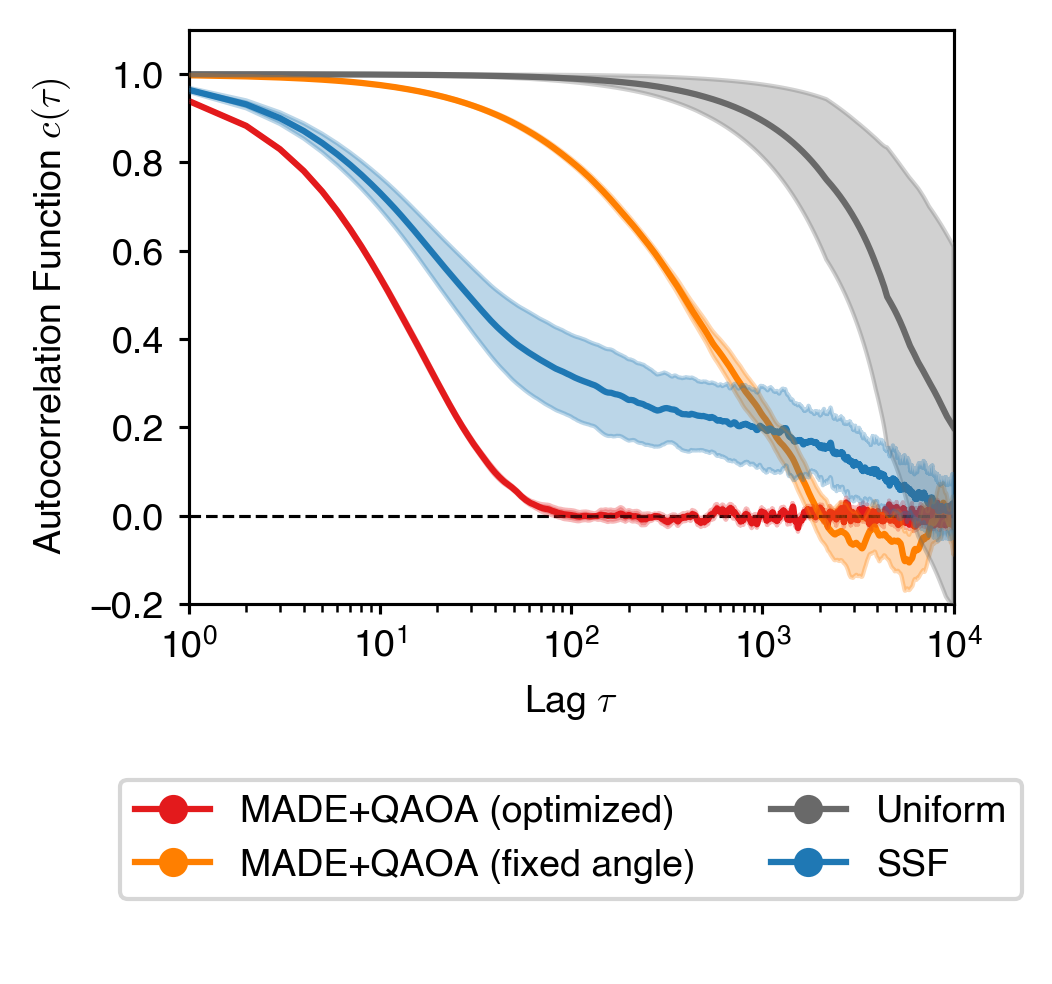

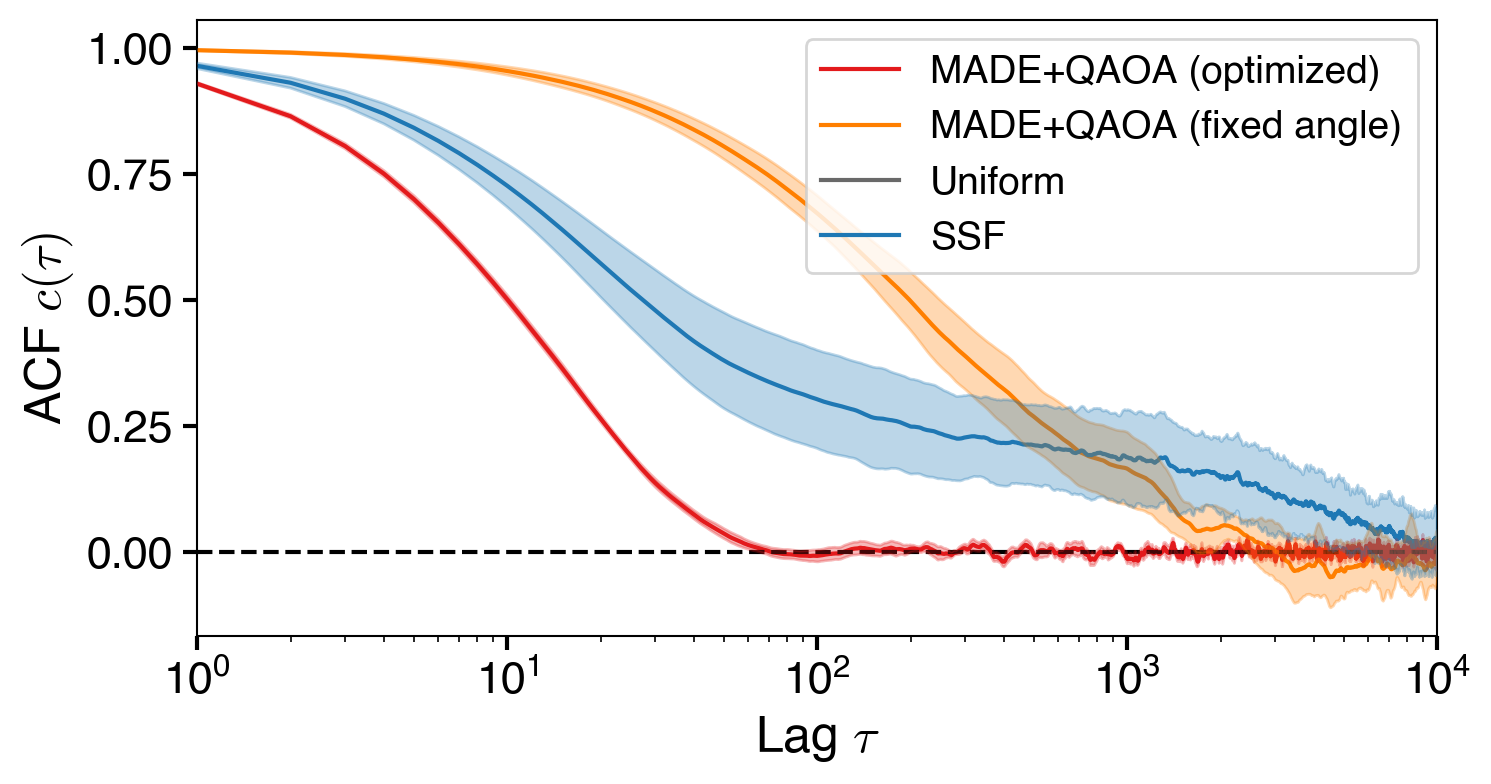

In [185]:
lag_2 = 10000

print(sqrt_mag_acf_history_uni[:,:10])

mag_acf_opt_made_ave = np.average(mag_acf_history_opt_made, axis=0)
mag_acf_opt_made_std = np.std(mag_acf_history_opt_made, axis=0)
mag_acf_fix_made_ave = np.average(mag_acf_history_fix_made, axis=0)
mag_acf_fix_made_std = np.std(mag_acf_history_fix_made, axis=0)
mag_acf_uni_ave = np.average(mag_acf_history_uni, axis=0)
mag_acf_uni_std = np.std(mag_acf_history_uni, axis=0)
mag_acf_ssf_ave = np.average(mag_acf_history_ssf, axis=0)
mag_acf_ssf_std = np.std(mag_acf_history_ssf, axis=0)

capsize = 2
markersize = 4
elinewidth = 1.5
capthick = 1.5
linewidth = 1.5
spines = 0.75
fontsize = 9

fig4_1, ax4_1 = plt.subplots(2,1, figsize=(3.29,4), gridspec_kw=dict(height_ratios=[5,2], hspace=0.3), dpi=300)

ax4_1[0].spines["top"].set_linewidth(spines)
ax4_1[0].spines["left"].set_linewidth(spines)
ax4_1[0].spines["bottom"].set_linewidth(spines)
ax4_1[0].spines["right"].set_linewidth(spines)

ax4_1[0].plot(np.arange(lag_2), mag_acf_opt_made_ave[:lag_2], color=red, linewidth=linewidth, label='MADE+QAOA (optimized)')
ax4_1[0].fill_between(np.arange(lag_2), mag_acf_opt_made_ave[:lag_2]+mag_acf_opt_made_std[:lag_2], mag_acf_opt_made_ave[:lag_2]-mag_acf_opt_made_std[:lag_2], color=red, alpha=0.3, zorder=4)
ax4_1[0].plot(np.arange(lag_2), mag_acf_fix_made_ave[:lag_2], color=orange, linewidth=linewidth, label='MADE+QAOA (fixed angle)')
ax4_1[0].fill_between(np.arange(lag_2), mag_acf_fix_made_ave[:lag_2]+mag_acf_fix_made_std[:lag_2], mag_acf_fix_made_ave[:lag_2]-mag_acf_fix_made_std[:lag_2], color=orange, alpha=0.3, zorder=4)
ax4_1[0].plot(np.arange(lag_2), mag_acf_uni_ave[:lag_2], color='dimgrey', linewidth=linewidth, label='Uniform')
ax4_1[0].fill_between(np.arange(lag_2), mag_acf_uni_ave[:lag_2]+mag_acf_uni_std[:lag_2], mag_acf_uni_ave[:lag_2]-mag_acf_uni_std[:lag_2], color='dimgrey', alpha=0.3, zorder=4)
ax4_1[0].plot(np.arange(lag_2), mag_acf_ssf_ave[:lag_2], color=blue, linewidth=linewidth, label='SSF')
ax4_1[0].fill_between(np.arange(lag_2), mag_acf_ssf_ave[:lag_2]+mag_acf_ssf_std[:lag_2], mag_acf_ssf_ave[:lag_2]-mag_acf_ssf_std[:lag_2], color=blue, alpha=0.3, zorder=4)

ax4_1[0].axhline(0.0, color='black', linestyle='--', linewidth=spines)

ax4_1[0].set_xlim(1, lag_2)
ax4_1[0].set_ylim(-0.2, 1.1)
ax4_1[0].set_xscale('log')
ax4_1[0].set_xlabel(r'Lag $\tau$', fontsize=fontsize)
ax4_1[0].set_ylabel(r'Autocorrelation Function $c(\tau)$', fontsize=fontsize)
ax4_1[0].tick_params(width=0.75, labelsize=fontsize, length=2.5, labelbottom=True)
ax4_1[0].tick_params(axis="x", which='major', width=0.75)
#ax4_1.legend(fontsize=fontsize, loc='lower center', bbox_to_anchor=(0.5, -0.5), ncol=2, frameon=True)

ax4_1[-1].plot([], [], marker='o', color=red, label='MADE+QAOA (optimized)', linestyle=None)
ax4_1[-1].plot([], [], marker='o', color=orange, label='MADE+QAOA (fixed angle)', linestyle=None)
ax4_1[-1].plot([], [], marker='o', color='dimgrey', label='Uniform', linestyle=None)
ax4_1[-1].plot([], [], marker='o', color=blue, label='SSF', linestyle=None)

for spine in ax4_1[-1].spines.values():
    spine.set_visible(False)
ax4_1[-1].axes.get_xaxis().set_visible(False)
ax4_1[-1].axes.get_yaxis().set_visible(False)
ax4_1[-1].legend(fontsize=fontsize, bbox_to_anchor=(0.5,0.5), loc='center', ncol=2, frameon=True)

fig4_1.savefig("figure/mag_acf_result.svg", dpi=300, bbox_inches='tight')
#fig4_1.savefig("figure/mag_acf_result.png", dpi=300, bbox_inches='tight')

sqrt_mag_acf_opt_made_ave = np.average(sqrt_mag_acf_history_opt_made, axis=0)
sqrt_mag_acf_opt_made_std = np.std(sqrt_mag_acf_history_opt_made, axis=0)
sqrt_mag_acf_fix_made_ave = np.average(sqrt_mag_acf_history_fix_made, axis=0)
sqrt_mag_acf_fix_made_std = np.std(sqrt_mag_acf_history_fix_made, axis=0)
sqrt_mag_acf_uni_ave = np.average(sqrt_mag_acf_history_uni, axis=0)
sqrt_mag_acf_uni_std = np.std(sqrt_mag_acf_history_uni, axis=0)
sqrt_mag_acf_ssf_ave = np.average(sqrt_mag_acf_history_ssf, axis=0)
sqrt_mag_acf_ssf_std = np.std(sqrt_mag_acf_history_ssf, axis=0)

fig4_2, ax4_2 = plt.subplots(figsize=(8,4), dpi=200)

ax4_2.spines["top"].set_linewidth(spines)
ax4_2.spines["left"].set_linewidth(spines)
ax4_2.spines["bottom"].set_linewidth(spines)
ax4_2.spines["right"].set_linewidth(spines)

ax4_2.plot(np.arange(lag_2), sqrt_mag_acf_opt_made_ave[:lag_2], color=red, linewidth=linewidth, label='MADE+QAOA (optimized)')
ax4_2.fill_between(np.arange(lag_2), sqrt_mag_acf_opt_made_ave[:lag_2]+sqrt_mag_acf_opt_made_std[:lag_2], sqrt_mag_acf_opt_made_ave[:lag_2]-sqrt_mag_acf_opt_made_std[:lag_2], color=red, alpha=0.3, zorder=4)
ax4_2.plot(np.arange(lag_2), sqrt_mag_acf_fix_made_ave[:lag_2], color=orange, linewidth=linewidth, label='MADE+QAOA (fixed angle)')
ax4_2.fill_between(np.arange(lag_2), sqrt_mag_acf_fix_made_ave[:lag_2]+sqrt_mag_acf_fix_made_std[:lag_2], sqrt_mag_acf_fix_made_ave[:lag_2]-sqrt_mag_acf_fix_made_std[:lag_2], color=orange, alpha=0.3, zorder=4)
ax4_2.plot(np.arange(lag_2), sqrt_mag_acf_uni_ave[:lag_2], color='dimgrey', linewidth=linewidth, label='Uniform')
ax4_2.fill_between(np.arange(lag_2), sqrt_mag_acf_uni_ave[:lag_2]+sqrt_mag_acf_uni_std[:lag_2], sqrt_mag_acf_uni_ave[:lag_2]-sqrt_mag_acf_uni_std[:lag_2], color='dimgrey', alpha=0.3, zorder=4)
ax4_2.plot(np.arange(lag_2), sqrt_mag_acf_ssf_ave[:lag_2], color=blue, linewidth=linewidth, label='SSF')
ax4_2.fill_between(np.arange(lag_2), sqrt_mag_acf_ssf_ave[:lag_2]+sqrt_mag_acf_ssf_std[:lag_2], sqrt_mag_acf_ssf_ave[:lag_2]-sqrt_mag_acf_ssf_std[:lag_2], color=blue, alpha=0.3, zorder=4)

ax4_2.axhline(0.0, color='black', linestyle='--', linewidth=linewidth)

ax4_2.set_xlim(1, lag_2)
ax4_2.set_xscale('log')
ax4_2.set_xlabel(r'Lag $\tau$', fontsize=18)
ax4_2.set_ylabel(r'ACF $c(\tau)$', fontsize=18)
ax4_2.tick_params(width=1.5, labelsize=16, length=5, labelbottom=True)
ax4_2.tick_params(axis="x", which='major', width=1.5)
ax4_2.legend(fontsize=14, loc='upper right', frameon=True)

### 磁化ヒストグラム

In [95]:
# インスタンス取得
source_dir_name = 'data'
fname_in = pathlib.Path(source_dir_name).joinpath('{0}_sites_energy_sort_idx.npy'.format(n_spin))
energy_sort_idx = np.load(fname_in)

# エネルギー下位３つの配置を取得
print(energy_sort_idx[0:20])
state = np.array([ising.number_to_spin(energy_sort_idx[i], n_spin) for i in range(20)])
energy = np.array([ising.spin_energy(state[i], instance) for i in range(state.shape[0])])
print(energy)
print(np.average(state, axis=1))


[24033178  9521253  9521765 24032666 24000155 24048283  9554276  9506148
 32421784  1132647 23999131  9555300  9538916 24015515  9514340 24040091
  9521255 24033176  1125732 32428699]
[-18.3260315  -18.3260315  -17.88941916 -17.88941916 -17.83081035
 -17.82655591 -17.83081035 -17.82655591 -17.75733508 -17.75733508
 -17.74165466 -17.74165466 -17.60738867 -17.60738867 -17.58769164
 -17.58769164 -17.56282394 -17.56282394 -17.50277011 -17.50277011]
[-0.28  0.28  0.2  -0.2  -0.2  -0.28  0.2   0.28 -0.28  0.28 -0.12  0.12
  0.2  -0.2   0.2  -0.2   0.2  -0.2   0.28 -0.28]


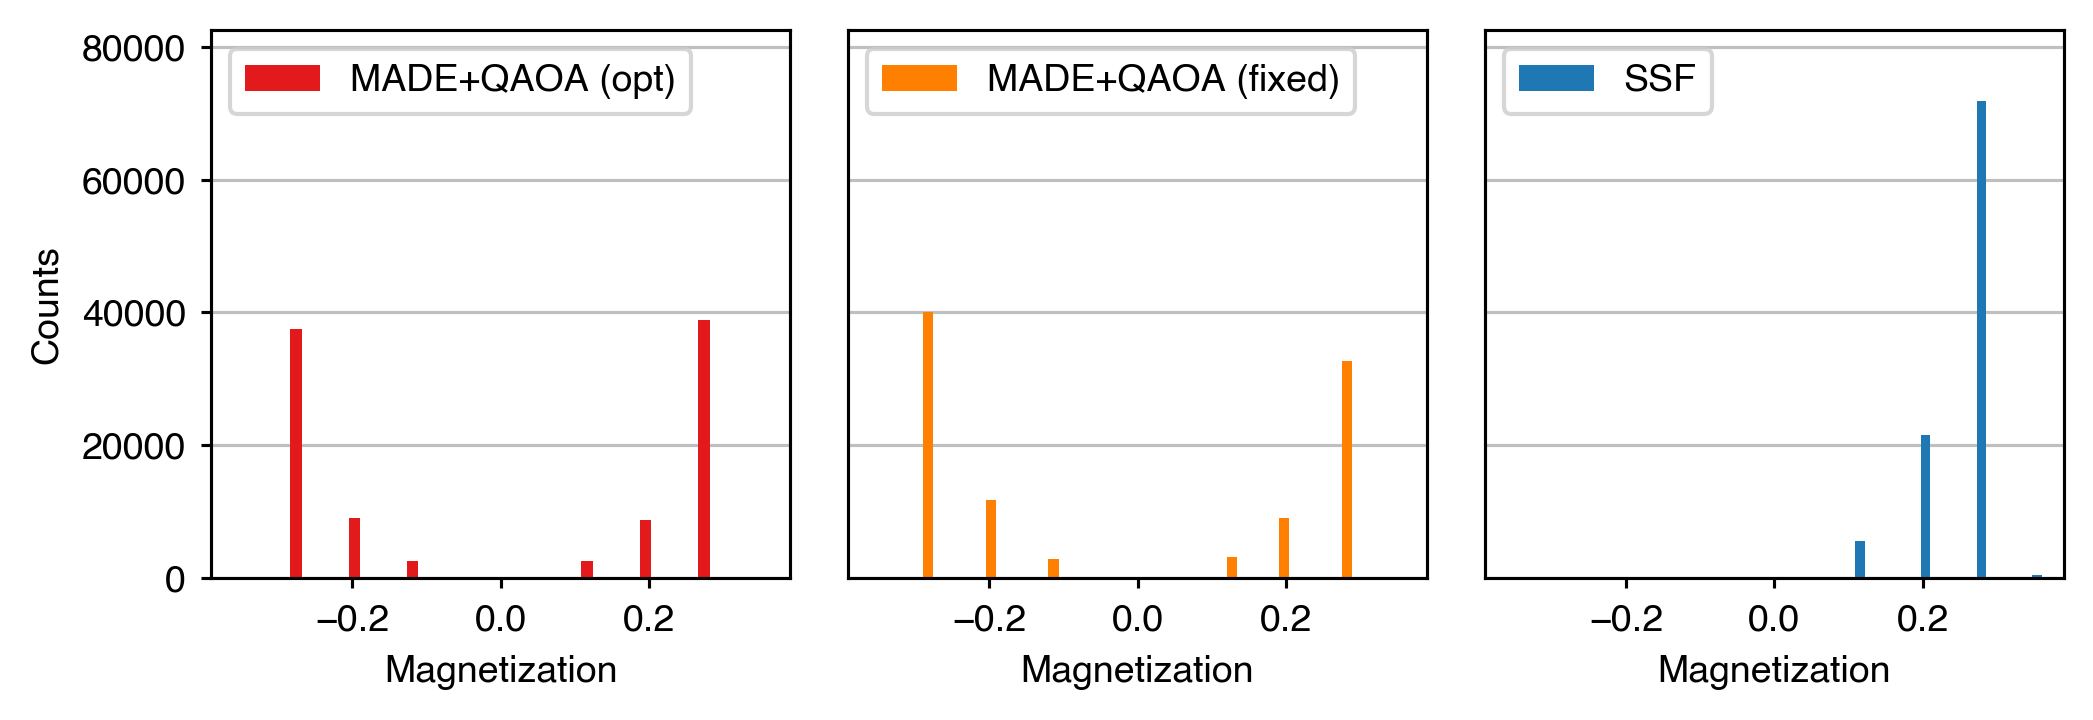

In [186]:
idx = 1

fig5, ax5 = plt.subplots(1,3, figsize=(7.08,2.5), dpi=300)

capsize = 2
markersize = 4
elinewidth = 1.5
capthick = 1.5
linewidth = 1.5
spines = 0.75
fontsize = 9

ax5[0].spines["top"].set_linewidth(spines)
ax5[0].spines["left"].set_linewidth(spines)
ax5[0].spines["bottom"].set_linewidth(spines)
ax5[0].spines["right"].set_linewidth(spines)

ax5[0].hist(opt_qaoa_made_mag[idx], bins=51, color=red, label='MADE+QAOA (opt)', zorder=2)
ax5[0].grid(axis='y', color='#BFBFBF', linestyle='-', linewidth=spines, zorder=1)
ax5[0].set_ylim(0,82500)
ax5[0].set_xlim(-0.39,0.39)
ax5[0].set_xlabel('Magnetization', fontsize=fontsize)
ax5[0].set_ylabel('Counts', fontsize=fontsize)
#ax5[0].set_title("(i) QAOA+MADE (optimized)", fontsize=18)
ax5[0].tick_params(width=spines, labelsize=fontsize, length=2.5, labelbottom=True)
ax5[0].legend(fontsize=fontsize, loc='upper left')

ax5[1].spines["top"].set_linewidth(spines)
ax5[1].spines["left"].set_linewidth(spines)
ax5[1].spines["bottom"].set_linewidth(spines)
ax5[1].spines["right"].set_linewidth(spines)

ax5[1].hist(fix_qaoa_made_mag[idx], bins=51, color=orange, label='MADE+QAOA (fixed)', zorder=2)
ax5[1].grid(axis='y', color='#BFBFBF', linestyle='-', linewidth=spines, zorder=1)
ax5[1].set_ylim(0,82500)
ax5[1].set_xlim(-0.39,0.39)
ax5[1].set_xlabel('Magnetization', fontsize=fontsize)
#ax5[1].set_ylabel('Counts', fontsize=18)
#ax5[1].set_title("(ii) QAOA+MADE (fixed angle)", fontsize=18)
ax5[1].tick_params(width=spines, labelsize=fontsize, length=2.5, labelbottom=True, labelleft=False)
ax5[1].tick_params(axis="y", which='major', width=0.0)
ax5[1].legend(fontsize=fontsize, loc='upper left')

ax5[2].spines["top"].set_linewidth(spines)
ax5[2].spines["left"].set_linewidth(spines)
ax5[2].spines["bottom"].set_linewidth(spines)
ax5[2].spines["right"].set_linewidth(spines)

ax5[2].hist(ssf_mag[idx], bins=51, color=blue, label='SSF', zorder=2)
ax5[2].grid(axis='y', color='#BFBFBF', linestyle='-', linewidth=spines, zorder=1)
ax5[2].set_ylim(0,82500)
ax5[2].set_xlim(-0.39,0.39)
ax5[2].set_xlabel('Magnetization', fontsize=fontsize)
#ax5[2].set_ylabel('Counts', fontsize=18)
#ax5[2].set_title("(iii) SSF", fontsize=18)
ax5[2].tick_params(width=spines, labelsize=fontsize, length=2.5, labelbottom=True, labelleft=False)
ax5[2].tick_params(axis="y", which='major', width=0.0)
ax5[2].legend(fontsize=fontsize, loc='upper left')

plt.tight_layout()
plt.subplots_adjust(wspace=0.1)
fig5.savefig("figure/magnetization_histogram.svg", dpi=300, bbox_inches='tight')
#fig5.savefig("figure/mag_est_result.png", dpi=300, bbox_inches='tight')